<a href="https://colab.research.google.com/github/yen010390/Classify-the-topic-of-an-article/blob/main/Project_3_1_Classify_the_topic_of_an_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Thư viện**

In [61]:
import os, re, json, random, warnings
from typing import List, Optional
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

# imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    _IMB_OK = True
except Exception:
    _IMB_OK = False
    warnings.warn("imbalanced-learn chưa cài; SMOTE/ROS/RUS sẽ bị tắt. pip install imbalanced-learn")

warnings.filterwarnings("ignore")

SEED = 42
RANDOM_STATE = 42
CACHE_DIR = "./cache"

In [62]:
def make_splits(
    X, y,
    test_size: float = 0.2,
    val_ratio: float = 0.5,
    seed: int = SEED
):
    """
    Trả về: X_train, X_val, X_test, y_train, y_val, y_test
    Test = test_size; Validation = val_ratio trên phần còn lại.
    """
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=val_ratio, random_state=seed, stratify=y_tmp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def save_splits(
    X_train, X_val, X_test, y_train, y_val, y_test,
    outdir: str = "splits", target_name: str = "target"
):
    out = Path(outdir); out.mkdir(parents=True, exist_ok=True)
    for name, (X_, y_) in {
        "raw_train": (X_train, y_train),
        "raw_val":   (X_val,   y_val),
        "raw_test":  (X_test,  y_test),
    }.items():
        y_series = pd.Series(y_, name=target_name) if not isinstance(y_, pd.Series) else y_.rename(target_name)
        pd.concat([pd.DataFrame(X_) if not isinstance(X_, pd.DataFrame) else X_, y_series], axis=1) \
          .to_csv(out / f"{name}.csv", index=False)

In [60]:
#Tạo block cấu hình đường dẫn/ Figure/Report paths
from types import SimpleNamespace

FIG_ROOT = os.path.join("pdf", "Figures")
PATHS = SimpleNamespace(
    root=FIG_ROOT,
    balanced=os.path.join(FIG_ROOT, "balanced"),
    all_models=os.path.join(FIG_ROOT, "all_models"),
)

# Tạo thư mục
for d in (PATHS.root, PATHS.balanced, PATHS.all_models):
    os.makedirs(d, exist_ok=True)

#**2. Xử lý dữ liệu**

In [3]:
# Load the dataset from the specified cache directory
ds = load_dataset("UniverseTBD/arxiv-abstracts-large", cache_dir=CACHE_DIR)
ds

README.md:   0%|          | 0.00/810 [00:00<?, ?B/s]

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [4]:
all_categories = ds['train']['categories'][:1000]
print(set(all_categories))

{'physics.ed-ph quant-ph', 'math.AP', 'math.PR math.ST stat.TH', 'math.CV math.SP', 'nlin.CD cond-mat.other physics.optics', 'math.AT math.DG', 'math.AP math-ph math.MP', 'cond-mat.supr-con cond-mat.str-el', 'q-bio.BM', 'nucl-th hep-ph', 'physics.gen-ph q-bio.PE', 'math.SG math.AG', 'cond-mat.soft cond-mat.stat-mech', 'math.DG gr-qc', 'cond-mat.mtrl-sci', 'physics.comp-ph physics.chem-ph', 'q-fin.RM math.PR', 'astro-ph gr-qc nucl-th', 'cond-mat.soft', 'q-bio.QM q-bio.MN', 'physics.optics physics.class-ph quant-ph', 'math.AG math.CV', 'math.LO math.CO', 'cond-mat.other', 'cond-mat.stat-mech cond-mat.soft', 'math.AG', 'hep-ph hep-ex nucl-ex', 'math.CO math.AC math.AG', 'quant-ph', 'physics.bio-ph', 'math.AG math.ST stat.TH', 'math.DG', 'math-ph math.GT math.MP', 'cond-mat.mtrl-sci cond-mat.other', 'math.DS', 'quant-ph hep-th', 'physics.optics physics.class-ph', 'math-ph hep-th math.MP', 'nucl-ex', 'physics.plasm-ph', 'cond-mat.stat-mech math-ph math.MP', 'cond-mat.str-el cond-mat.supr-co

In [5]:
all_categories = ds['train']['categories']
category_set = set()

# Collect unique labels
for category in all_categories:
    parts = category.split(' ')
    for part in parts:
        topic = part.split('.')[0]
        category_set.add(topic)

# Sort the labels and print them
sorted_categories= sorted(list(category_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset:')
for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [6]:
# load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in ds['train']:
    if len(s['categories'].split(' ')) != 1:
        continue

    cur_category = s['categories'].strip().split('.')[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 1000:
        break
print(f"Number of samples: {len(samples)}")

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 1000
Category: physics.gen-ph
Abstract:   The evolution of Earth-Moon system is described by the dark matter field
fluid model proposed in the Meeting of Division of Particle and Field 2004,
American Physical Society. The current behavior of the Earth-Moon system agrees
with this model very well and the general pattern of the evolution of the
Moon-Earth system described by this model agrees with geological and fossil
evidence. The closest distance of the Moon to Earth was about 259000 km at 4.5
billion years ago, which is far beyond the Roche's limit. The result suggests
that the tidal friction may not be the primary cause for the evolution of the
Earth-Moon system. The average dark matter field fluid constant derived from
Earth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts
that the Mars's rotation is also slowing with the angular acceleration rate
about -4.38 x 10^(-22) rad s^(-2).

####################

Category: math.CO
Abstract:   We show 

In [7]:
preprocessed_samples = []
for s in samples:
    abstract = s['abstract']

    # Remove \n characters in the middle and leading/trailing spaces
    abstract = abstract.strip().replace("\n", " ")

    # Remove special characters
    abstract = re.sub(r'[^\w\s]', '', abstract)

    # Remove digits
    abstract = re.sub(r'\d+', '', abstract)

    # Remove extra spaces
    abstract = re.sub(r'\s+', ' ', abstract).strip()

    # Convert to lower case
    abstract = abstract.lower()

    # for the label, we only keep the first part
    parts = s['categories'].split(' ')
    category = parts[0].split('.')[0]

    preprocessed_samples.append({
        "text": abstract,
        "label": category
    })

# print first 3 preprocessed samples
for sample in preprocessed_samples[:3]:
    print(f"Label: {sample['label']}")
    print("Text:", sample['text'])
    print("#" * 20 + "\n")

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about km at billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is x sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about x rad s
####################

Label: math
Text: we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves a bijection from 

In [8]:
labels = set([s['label'] for s in preprocessed_samples])
# Sort and print unique labels
sorted_labels = sorted(labels)
for label in sorted_labels:
    print(label)

astro-ph
cond-mat
cs
math
physics


In [9]:
label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")

Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [10]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


In [11]:
if 'preprocessor' not in globals():
    print("ℹ️ Không thấy `preprocessor`, tạo nhanh preprocessor mặc định.")
    numerical_cols = ['age','trestbps','chol','thalach','oldpeak']
    categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                              ('scaler', StandardScaler())]), numerical_cols),
            ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                              ('ohe', ohe)]), categorical_cols)
        ]
    )

ℹ️ Không thấy `preprocessor`, tạo nhanh preprocessor mặc định.


# **3. Tăng cường dữ liệu**

In [12]:
# 🔁 Data Augmentation + Class-Balanced Upsampling (put this right after train_test_split)

# ⚙️ Config
AUGMENT_ENABLED      = True      # tắt/mở augmentation
TARGET_PER_CLASS     = 300       # mỗi lớp sẽ được tăng lên tối đa mức này (hoặc max hiện có, tuỳ lớp)
ALPHA_DELETE         = 0.10      # xác suất xoá từ
ALPHA_SWAP           = 0.10      # tỷ lệ hoán vị ~ (ALPHA_SWAP * số từ)
ALPHA_SYNONYM_RATIO  = 0.10      # tỷ lệ từ sẽ được thay bằng đồng nghĩa (nếu có wordnet)
NUM_AUG_PER_SAMPLE   = 1         # mỗi văn bản gốc sinh ra bao nhiêu biến thể
RANDOM_SEED          = 42

random.seed(RANDOM_SEED)

#WordNet synonyms
try:
    import nltk
    nltk.data.find('corpora/wordnet')
except Exception:
    try:
        import nltk
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
    except Exception:
        pass

try:
    from nltk.corpus import wordnet as wn
    _WORDNET_OK = True
except Exception:
    _WORDNET_OK = False

def _tokenize_simple(s: str) -> List[str]:
    return s.split()

def _random_deletion(tokens: List[str], p: float) -> List[str]:
    if not tokens:
        return tokens
    out = [t for t in tokens if random.random() > p]
    return out if out else tokens  # không để rỗng

def _random_swap(tokens: List[str], n_swaps: int) -> List[str]:
    if len(tokens) < 2 or n_swaps <= 0:
        return tokens
    tokens = tokens.copy()
    for _ in range(n_swaps):
        i, j = random.sample(range(len(tokens)), 2)
        tokens[i], tokens[j] = tokens[j], tokens[i]
    return tokens

def _get_synonyms(word: str) -> List[str]:
    if not _WORDNET_OK or not word.isalpha():
        return []
    syns = set()
    for syn in wn.synsets(word):
        for lem in syn.lemmas():
            w = lem.name().replace('_', ' ').lower()
            if w != word:
                syns.add(w)
    return list(syns)

def _random_synonym_replace(tokens: List[str], ratio: float) -> List[str]:
    if not _WORDNET_OK or ratio <= 0 or not tokens:
        return tokens
    tokens = tokens.copy()
    n_changes = max(1, int(len(tokens) * ratio))
    idxs = list(range(len(tokens)))
    random.shuffle(idxs)
    changed = 0
    for i in idxs:
        syns = _get_synonyms(tokens[i])
        if syns:
            tokens[i] = random.choice(syns)
            changed += 1
        if changed >= n_changes:
            break
    return tokens

def eda_augment(text: str,
                alpha_del=ALPHA_DELETE,
                alpha_swap=ALPHA_SWAP,
                alpha_syn=ALPHA_SYNONYM_RATIO,
                num_aug=NUM_AUG_PER_SAMPLE) -> List[str]:
    """
    EDA cơ bản: xoá, hoán vị, thay từ đồng nghĩa (nếu có).
    """
    out = []
    base_tokens = _tokenize_simple(text)
    for _ in range(num_aug):
        tokens = base_tokens
        # xoá ngẫu nhiên
        tokens = _random_deletion(tokens, alpha_del)
        # hoán vị ngẫu nhiên
        n_swaps = max(1, int(len(tokens) * alpha_swap)) if len(tokens) > 1 else 0
        tokens = _random_swap(tokens, n_swaps)
        # thay từ đồng nghĩa
        tokens = _random_synonym_replace(tokens, alpha_syn)
        out.append(' '.join(tokens))
    return out

def augment_and_balance(X_train: List[str],
                        y_train: List[int],
                        target_per_class: int = TARGET_PER_CLASS,
                        seed: int = RANDOM_SEED):
    """
    Tăng cường + cân bằng theo lớp cho tới khi mỗi lớp đạt ít nhất target_per_class
    (hoặc tới mức gần nhất có thể).
    """
    random.seed(seed)
    X_train = list(X_train)
    y_train = list(y_train)

    counts = Counter(y_train)
    classes = sorted(counts.keys())
    cur_max = max(counts.values()) if counts else 0
    target = max(min(target_per_class, max(cur_max, 1)), 1)

    # Gom văn bản theo lớp
    by_class = {c: [x for x, y in zip(X_train, y_train) if y == c] for c in classes}

    X_aug, y_aug = [], []
    for c in classes:
        texts = by_class[c]
        need = max(0, target - len(texts))
        if need == 0 or not texts:
            continue

        # Lặp qua văn bản gốc, sinh biến thể cho tới khi đủ
        i = 0
        while need > 0:
            t = texts[i % len(texts)]
            for aug in eda_augment(t):
                X_aug.append(aug)
                y_aug.append(c)
                need -= 1
                if need <= 0:
                    break
            i += 1

    # Ghép vào train
    X_new = X_train + X_aug
    y_new = y_train + y_aug

    after = Counter(y_new)
    print("🔧 Augmented per-class counts:", dict(after))
    print(f"🔼 Train size: {len(X_train)} → {len(X_new)} (added {len(X_aug)})")
    return X_new, y_new

# Thực thi augmentation (nếu bật)
if AUGMENT_ENABLED:
    X_train, y_train = augment_and_balance(
        X_train, y_train, target_per_class=TARGET_PER_CLASS, seed=RANDOM_SEED
    )
else:
    print("Augmentation disabled — skipping.")

🔧 Augmented per-class counts: {1: 300, 0: 347, 4: 300, 3: 300, 2: 300}
🔼 Train size: 800 → 1547 (added 747)


In [13]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow  = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

In [65]:
#EmbeddingVectorizer
class EmbeddingVectorizer:
    def __init__(self, model_name: str = "intfloat/multilingual-e5-base",
                 normalize: bool = True, device: Optional[str] = None):
        self.model = SentenceTransformer(model_name, device=device)
        self.normalize = normalize

    def _format_inputs(self, texts: List[str], mode: str = "query") -> List[str]:
        if mode == "raw":
            return texts
        if mode not in {"query", "passage"}:
            raise ValueError("mode phải là 'query', 'passage' hoặc 'raw'")
        return [f"{mode}: {t.strip()}" for t in texts]

    def transform_numpy(self, texts: List[str], mode: str = "query") -> np.ndarray:
        inputs = self._format_inputs(texts, mode)
        embs = self.model.encode(inputs,
                                 normalize_embeddings=self.normalize,
                                 convert_to_numpy=True,
                                 batch_size=64,
                                 show_progress_bar=False)
        return embs

In [15]:
#Tạo embedding
embedding_vectorizer = EmbeddingVectorizer()  # mặc định 'intfloat/multilingual-e5-base'
X_train_embeddings = embedding_vectorizer.transform_numpy(X_train)  # shape (N, 768)
X_test_embeddings  = embedding_vectorizer.transform_numpy(X_test)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

# **4. Cân bằng dữ liệu train**

In [66]:
BALANCE_BOW      = "over"   # 'none' | 'over' | 'under'  (không khuyến nghị 'smote' cho sparse)
BALANCE_TFIDF    = "over"   # 'none' | 'over' | 'under'
BALANCE_EMB      = "smote"  # 'none' | 'over' | 'under' | 'smote' (SMOTE tốt cho embeddings)

def _print_counts(y, note):
    cnt = Counter(y)
    print(f"{note} — số mẫu theo lớp:", dict(sorted(cnt.items())))

def _fallback_resample_over(X, y):
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    idx_all = np.arange(len(y))
    idx_new = np.concatenate([
        np.tile(idx_all[y == c], int(np.ceil(max_count / (y == c).sum())))[:max_count]
        for c in classes
    ])
    X_new = X[idx_new] if hasattr(X, "shape") or hasattr(X, "toarray") else [X[i] for i in idx_new]
    return X_new, y[idx_new]

def _fallback_resample_under(X, y):
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    rng = np.random.default_rng(SEED)
    idx_new = np.concatenate([
        rng.choice(np.where(y == c)[0], size=min_count, replace=False)
        for c in classes
    ])
    rng.shuffle(idx_new)
    X_new = X[idx_new] if hasattr(X, "shape") or hasattr(X, "toarray") else [X[i] for i in idx_new]
    return X_new, y[idx_new]

def make_balanced(X, y, strategy: str, for_embeddings: bool = False):
    """
    strategy: 'none' | 'over' | 'under' | 'smote'
    for_embeddings: True nếu là embeddings (dense) => cho phép SMOTE
    Tự suy ra sparse/dense từ X (không cần truyền is_sparse).
    """
    if strategy == "none":
        return X, y

    is_sparse = hasattr(X, "toarray")  # scipy sparse có .toarray
    if strategy == "smote":
        # chỉ chấp nhận cho embeddings (dense) và khi có imblearn
        if not for_embeddings or is_sparse or not _IMB_OK:
            print("⚠️ SMOTE không áp dụng cho sparse hoặc khi thiếu imblearn → dùng 'over'.")
            strategy = "over"

    if not _IMB_OK and strategy in {"over", "under"}:
        return _fallback_resample_over(X, y) if strategy == "over" else _fallback_resample_under(X, y)

    if strategy in {"over", "under"} and _IMB_OK:
        sampler = (RandomOverSampler if strategy == "over" else RandomUnderSampler)(random_state=SEED)
        y_arr = np.asarray(y)
        X_bal, y_bal = sampler.fit_resample(X, y_arr)
        return X_bal, y_bal

    if strategy == "smote":  # embeddings + imblearn
        y_arr = np.asarray(y)
        X_bal, y_bal = SMOTE(random_state=SEED, k_neighbors=5).fit_resample(X, y_arr)
        return X_bal, y_bal

    return X, y

In [67]:
# ===== Thực thi cân bằng =====
_print_counts(y_train, "Trước cân bằng")

X_train_bow_bal,   y_train_bow_bal   = make_balanced(X_train_bow,   y_train, strategy=BALANCE_BOW,   for_embeddings=False)
_print_counts(y_train_bow_bal,   f"BoW sau cân bằng ({BALANCE_BOW})")

X_train_tfidf_bal, y_train_tfidf_bal = make_balanced(X_train_tfidf, y_train, strategy=BALANCE_TFIDF, for_embeddings=False)
_print_counts(y_train_tfidf_bal, f"TF-IDF sau cân bằng ({BALANCE_TFIDF})")

X_train_emb_bal,   y_train_emb_bal   = make_balanced(X_train_embeddings, y_train, strategy=BALANCE_EMB, for_embeddings=True)
_print_counts(y_train_emb_bal,   f"Embeddings sau cân bằng ({BALANCE_EMB})")

Trước cân bằng — số mẫu theo lớp: {0: 347, 1: 300, 2: 300, 3: 300, 4: 300}
BoW sau cân bằng (over) — số mẫu theo lớp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}
TF-IDF sau cân bằng (over) — số mẫu theo lớp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}
Embeddings sau cân bằng (smote) — số mẫu theo lớp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}


# **5. Huấn luyện lại trên tập đã cân bằng**


In [64]:
# 🎯 Confusion matrices — Sau cân bằng
if 'sorted_labels' not in globals():
    uniq = sorted(set(y_test))
    sorted_labels = [str(i) for i in uniq]
labels_idx = list(range(len(sorted_labels)))

# ===== Kiểm tra biến cần thiết (fail sớm) =====
_required = [
    'X_train_bow_bal','y_train_bow_bal','X_test_bow',
    'X_train_tfidf_bal','y_train_tfidf_bal','X_test_tfidf',
    'X_train_emb_bal','y_train_emb_bal','X_test_embeddings',
    'y_test'
]
_missing = [v for v in _required if v not in globals()]
assert not _missing, f"Thiếu biến: {_missing}. Hãy chạy cell tiền xử lý / vector hóa trước."

# ===== Helpers chung =====
if 'cv' not in globals():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

if 'f1_scorer' not in globals():
    f1_scorer = make_scorer(f1_score, average='macro')

def _to_dense(X):
    """Ép dense cho GaussianNB/khi cần."""
    return X.toarray() if hasattr(X, "toarray") else X

def _safe_report(y_true, y_pred):
    return classification_report(y_true, y_pred, target_names=sorted_labels, output_dict=True)

def _summarize(name, y_true, y_pred):
    return dict(
        model_feature=name,
        accuracy=accuracy_score(y_true, y_pred),
        f1_macro=f1_score(y_true, y_pred, average="macro"),
        f1_weighted=f1_score(y_true, y_pred, average="weighted"),
    )

def plot_cv_curve(xs, ys, xlabel, title, semilog=False):
    plt.figure(figsize=(6,4))
    (plt.semilogx if semilog else plt.plot)(xs, ys, marker='o')
    plt.xlabel(xlabel); plt.ylabel('CV F1 (macro)')
    plt.title(title); plt.grid(True, alpha=.3)
    plt.tight_layout(); plt.show()

# # ========= Tabular preprocessor & make_clf_pipe=========
# def default_preprocessor():
#     """Tạo ColumnTransformer mặc định cho dữ liệu tabular (nếu cần)."""
#     from sklearn.compose import ColumnTransformer
#     from sklearn.preprocessing import OneHotEncoder, StandardScaler
#     from sklearn.impute import SimpleImputer
#     try:
#         ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#     except TypeError:
#         ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
#     numerical_cols = ['age','trestbps','chol','thalach','oldpeak']
#     categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
#     return ColumnTransformer([
#         ('num', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='median')),
#             ('scaler', StandardScaler())
#         ]), numerical_cols),
#         ('cat', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('ohe', ohe)
#         ]), categorical_cols),
#     ])

# def make_clf_pipe(clf, preprocessor=None, use_smote=False):
#     """
#     preprocessor: ColumnTransformer; nếu None sẽ dùng default_preprocessor().
#     use_smote: True để thêm SMOTE (cần imblearn + dữ liệu phù hợp).
#     """
#     from sklearn.pipeline import Pipeline
#     pre = default_preprocessor() if preprocessor is None else preprocessor

#     if use_smote and globals().get('_IMB_OK', False):
#         from imblearn.pipeline import Pipeline as ImbPipeline
#         from imblearn.over_sampling import SMOTE
#         return ImbPipeline([('pre', pre), ('smote', SMOTE(random_state=SEED)), ('clf', clf)])
#     return Pipeline([('pre', pre), ('clf', clf)])

# # ==== Tune trực tiếp trên text thô====
# def make_text_pipe(clf):
#     from sklearn.pipeline import Pipeline
#     from sklearn.feature_extraction.text import TfidfVectorizer
#     return Pipeline([
#         ('tfidf', TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1,2)) ),
#         ('clf', clf)
#     ])

# def cv_curve_text(estimator_factory, param_name, param_values, title):
#     from sklearn.model_selection import cross_val_score
#     scores = []
#     for v in param_values:
#         pipe = make_text_pipe(estimator_factory(v))
#         s = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=f1_scorer, n_jobs=-1)
#         scores.append(s.mean())
#     plot_cv_curve(param_values, scores, param_name, title)
#     best_v = param_values[int(np.argmax(scores))]
#     print(f"✅ {title} — best {param_name}: {best_v}")
#     return best_v

In [54]:
# KNN
def find_optimal_k_val(X_train, y_train, X_val, y_val, k_values=range(1, 21), plot=True):
    k_list = list(k_values)
    scores = []
    for k in k_list:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        scores.append(accuracy_score(y_val, clf.predict(X_val)))
    if plot:
        plt.figure()
        plt.plot(k_list, scores, marker="o")
        plt.xlabel("k"); plt.ylabel("Validation accuracy"); plt.grid(True); plt.title("Chọn k theo VAL")
        plt.show()
    return k_list[int(np.argmax(scores))]

def train_eval_knn(X_train, y_train, X_val, y_val, X_test, y_test, k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    print(f"[KNN] VAL acc={accuracy_score(y_val, y_val_pred):.4f}")
    print(classification_report(y_val, y_val_pred))
    print(f"[KNN] TEST acc={accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred))
    return model

In [53]:
# Decision Tree
def find_optimal_depth_cv(X_train, y_train, depth_range=range(1, 21), cv_splits=5, seed=SEED, plot=True):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)
    depths = list(depth_range)
    scores = []
    for d in depths:
        dt = DecisionTreeClassifier(max_depth=d, random_state=seed)
        scores.append(cross_val_score(dt, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1).mean())
    if plot:
        plt.figure()
        plt.plot(depths, scores, marker="o")
        plt.xlabel("Depth"); plt.ylabel(f"CV{cv_splits}-accuracy"); plt.grid(True); plt.title("Chọn depth theo CV")
        plt.show()
    return depths[int(np.argmax(scores))]

def train_eval_dt(X_train, y_train, X_val, y_val, X_test, y_test, depth, seed=SEED):
    model = DecisionTreeClassifier(max_depth=depth, random_state=seed)
    model.fit(X_train, y_train)
    for split_name, X_, y_ in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
        pred = model.predict(X_)
        print(f"[DT depth={depth}] {split_name} acc={accuracy_score(y_, pred):.4f}")
        print(classification_report(y_, pred))
    return model

def display_feature_importance_dt(model, X_cols):
    fi = pd.DataFrame({"feature": X_cols, "importance": model.feature_importances_}) \
            .sort_values("importance", ascending=False)
    print("\nTop 10 feature importances (DT):")
    display(fi.head(10))

In [69]:
# KMeans
def _cluster_majority_mapping(labels_train, y_train):
    y_train = np.asarray(y_train); mapping = {}
    for cid in np.unique(labels_train):
        mask = (labels_train == cid)
        base = y_train[mask] if np.any(mask) else y_train
        mapping[cid] = Counter(base).most_common(1)[0][0]
    return mapping

def evaluate_kmeans(X_train, y_train, X_val, y_val, X_test, y_test, n_clusters=2, seed=SEED, init="random"):
    km = KMeans(n_clusters=n_clusters, random_state=seed, init=init).fit(X_train)
    mapping = _cluster_majority_mapping(km.labels_, y_train)
    km.cluster_class_mapping_ = mapping
    for split_name, X_, y_ in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
        pred = np.array([mapping[c] for c in km.predict(X_)])
        print(f"[KMeans k={n_clusters}] {split_name} acc={accuracy_score(y_, pred):.4f}")
        print(classification_report(y_, pred))
    return km

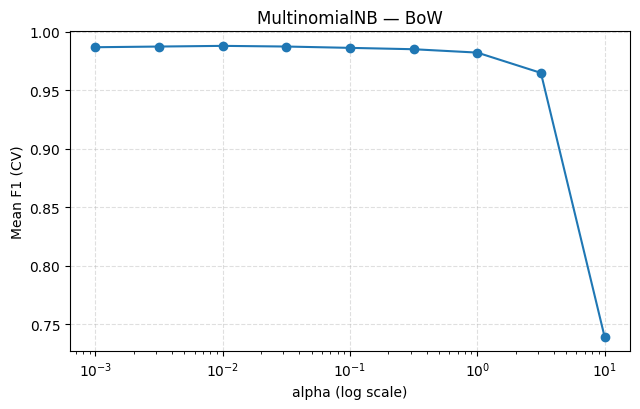

✅ MultinomialNB (BoW) — best alpha: 0.01


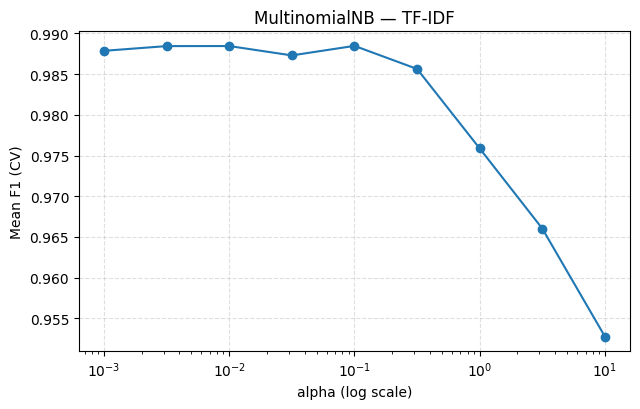

✅ MultinomialNB (TF-IDF) — best alpha: 0.1


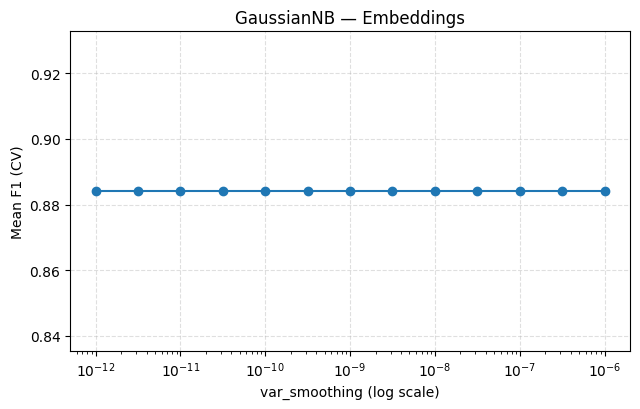

✅ GaussianNB (Embeddings) — best var_smoothing: 1.00e-12


In [70]:
# Naive Bayes
def _plot_semilog(xs, ys, xlabel, title):
    plt.figure(figsize=(6.5, 4.2))
    plt.semilogx(xs, ys, marker='o')
    plt.xlabel(xlabel); plt.ylabel("Mean F1 (CV)")
    plt.title(title); plt.grid(True, linestyle='--', alpha=.4)
    plt.tight_layout(); plt.show()

# BoW — MultinomialNB
alphas = np.logspace(-3, 1, 9)
mnnb_bow_gs = GridSearchCV(MultinomialNB(), {'alpha': alphas}, scoring=f1_scorer, cv=cv, n_jobs=-1, refit=True)
mnnb_bow_gs.fit(X_train_bow_bal, y_train_bow_bal)
means_bow = [cross_val_score(MultinomialNB(alpha=a), X_train_bow_bal, y_train_bow_bal, cv=cv,
                             scoring=f1_scorer, n_jobs=-1).mean() for a in alphas]
_plot_semilog(alphas, means_bow, "alpha (log scale)", "MultinomialNB — BoW")
best_alpha_bow = mnnb_bow_gs.best_params_['alpha']; print(f"✅ MultinomialNB (BoW) — best alpha: {best_alpha_bow:.3g}")
nb_bow = mnnb_bow_gs.best_estimator_; nb_bow_labels = nb_bow.predict(X_test_bow)

# TF-IDF — MultinomialNB
mnnb_tfidf_gs = GridSearchCV(MultinomialNB(), {'alpha': alphas}, scoring=f1_scorer, cv=cv, n_jobs=-1, refit=True)
mnnb_tfidf_gs.fit(X_train_tfidf_bal, y_train_tfidf_bal)
means_tfidf = [cross_val_score(MultinomialNB(alpha=a), X_train_tfidf_bal, y_train_tfidf_bal, cv=cv,
                               scoring=f1_scorer, n_jobs=-1).mean() for a in alphas]
_plot_semilog(alphas, means_tfidf, "alpha (log scale)", "MultinomialNB — TF-IDF")
best_alpha_tfidf = mnnb_tfidf_gs.best_params_['alpha']; print(f"✅ MultinomialNB (TF-IDF) — best alpha: {best_alpha_tfidf:.3g}")
nb_tfidf = mnnb_tfidf_gs.best_estimator_; nb_tfidf_labels = nb_tfidf.predict(X_test_tfidf)

# Embeddings — GaussianNB
Xtr_emb = _to_dense(X_train_emb_bal); Xte_emb = _to_dense(X_test_embeddings)
vs_grid = np.logspace(-12, -6, 13)
gnb_gs = GridSearchCV(GaussianNB(), {'var_smoothing': vs_grid}, scoring=f1_scorer, cv=cv, n_jobs=-1, refit=True)
gnb_gs.fit(Xtr_emb, y_train_emb_bal)
means_vs = [cross_val_score(GaussianNB(var_smoothing=v), Xtr_emb, y_train_emb_bal, cv=cv,
                            scoring=f1_scorer, n_jobs=-1).mean() for v in vs_grid]
_plot_semilog(vs_grid, means_vs, "var_smoothing (log scale)", "GaussianNB — Embeddings")
best_nb_vs = gnb_gs.best_params_['var_smoothing']; print(f"✅ GaussianNB (Embeddings) — best var_smoothing: {best_nb_vs:.2e}")
nb_emb = gnb_gs.best_estimator_; nb_emb_labels = nb_emb.predict(Xte_emb)

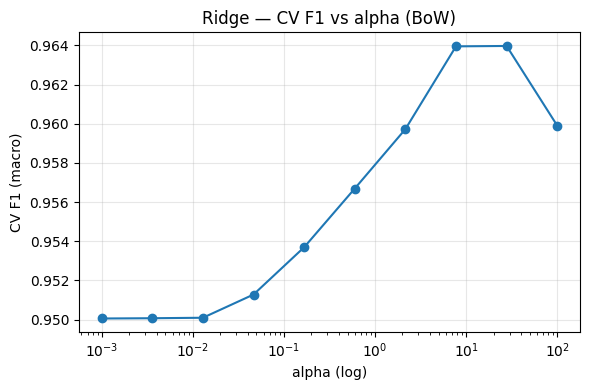

✅ Ridge (BoW) — best alpha: 27.83


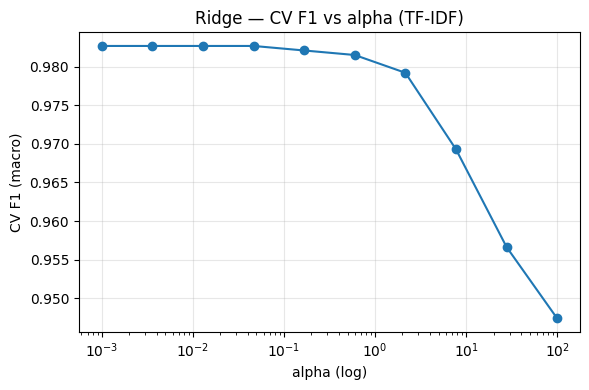

✅ Ridge (TF-IDF) — best alpha: 0.001


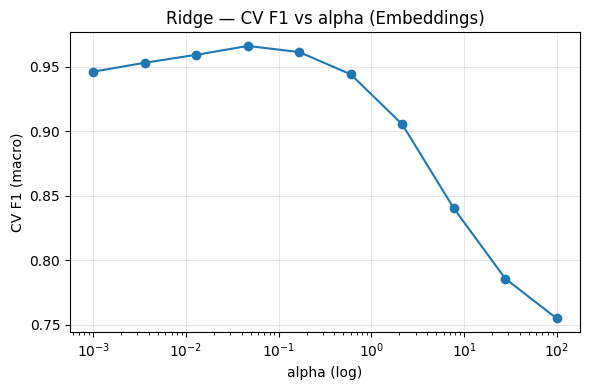

✅ Ridge (Emb) — best alpha: 0.04642


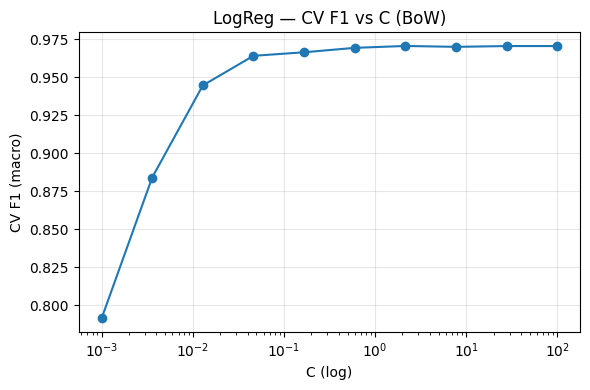

✅ LogReg (BoW) — best C: 2.154


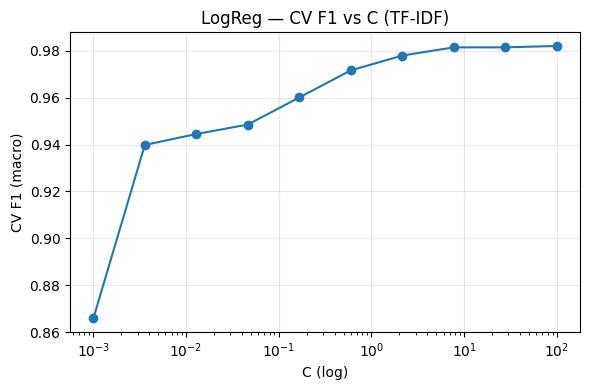

✅ LogReg (TF-IDF) — best C: 100


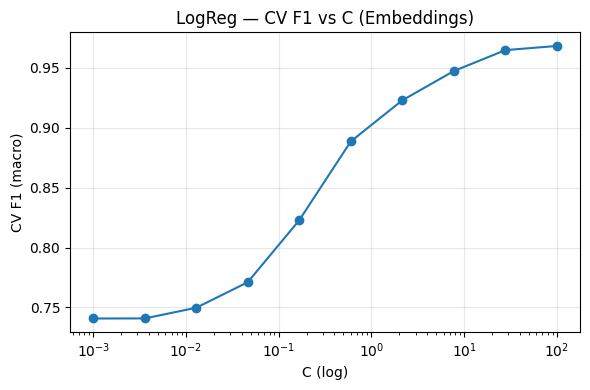

✅ LogReg (Emb) — best C: 100


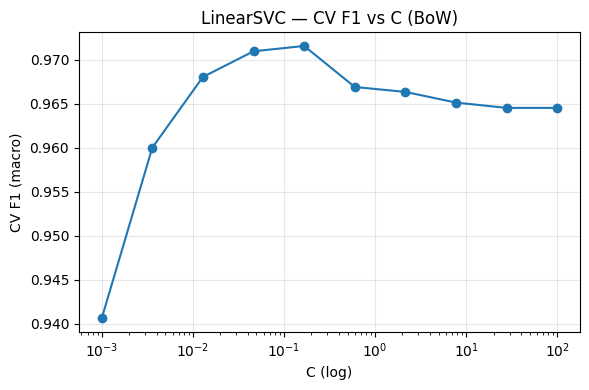

✅ LinearSVC (BoW) — best C: 0.1668


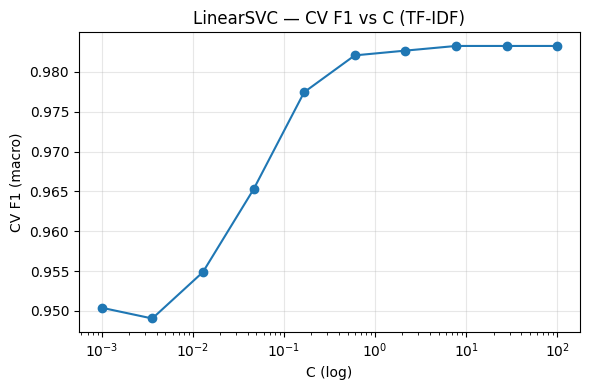

✅ LinearSVC (TF-IDF) — best C: 7.743


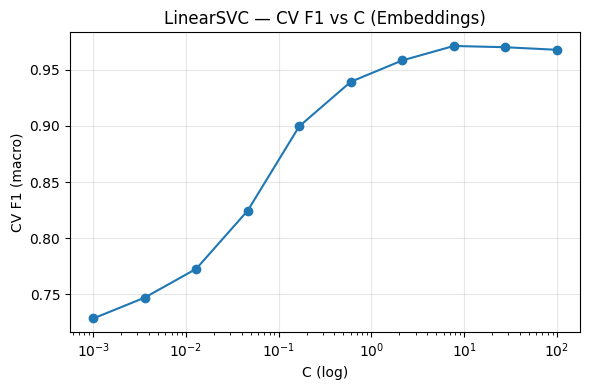

✅ LinearSVC (Emb) — best C: 7.743


In [71]:
# Ridge / Logistic Regression / LinearSVC
def tune_alpha_ridge(Xtr, ytr, title_suffix=""):
    alphas = np.logspace(-3, 2, 10); means = []
    for a in alphas:
        means.append(cross_val_score(RidgeClassifier(alpha=a, class_weight='balanced', random_state=SEED),
                                     Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_cv_curve(alphas, means, "alpha (log)", f"Ridge — CV F1 vs alpha {title_suffix}", semilog=True)
    return float(alphas[int(np.argmax(means))])

best_ridge_alpha_bow = tune_alpha_ridge(X_train_bow_bal, y_train_bow_bal, "(BoW)")
ridge_bow = RidgeClassifier(alpha=best_ridge_alpha_bow, class_weight='balanced', random_state=SEED).fit(X_train_bow_bal, y_train_bow_bal)
ridge_bow_labels = ridge_bow.predict(X_test_bow)
print(f"✅ Ridge (BoW) — best alpha: {best_ridge_alpha_bow:.4g}")

best_ridge_alpha_tfidf = tune_alpha_ridge(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
ridge_tfidf = RidgeClassifier(alpha=best_ridge_alpha_tfidf, class_weight='balanced', random_state=SEED).fit(X_train_tfidf_bal, y_train_tfidf_bal)
ridge_tfidf_labels = ridge_tfidf.predict(X_test_tfidf)
print(f"✅ Ridge (TF-IDF) — best alpha: {best_ridge_alpha_tfidf:.4g}")

best_ridge_alpha_emb = tune_alpha_ridge(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
ridge_emb = RidgeClassifier(alpha=best_ridge_alpha_emb, class_weight='balanced', random_state=SEED).fit(X_train_emb_bal, y_train_emb_bal)
ridge_emb_labels = ridge_emb.predict(X_test_embeddings)
print(f"✅ Ridge (Emb) — best alpha: {best_ridge_alpha_emb:.4g}")

def tune_C_logreg(Xtr, ytr, title_suffix=""):
    Cs = np.logspace(-3, 2, 10); means = []
    for C in Cs:
        clf = LogisticRegression(C=C, penalty='l2', solver='saga', max_iter=3000,
                                 class_weight='balanced', random_state=SEED, n_jobs=-1)
        means.append(cross_val_score(clf, Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_cv_curve(Cs, means, "C (log)", f"LogReg — CV F1 vs C {title_suffix}", semilog=True)
    return float(Cs[int(np.argmax(means))])

best_logreg_C_bow = tune_C_logreg(X_train_bow_bal, y_train_bow_bal, "(BoW)")
log_bow = LogisticRegression(C=best_logreg_C_bow, penalty='l2', solver='saga', max_iter=3000,
                             class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_bow_bal, y_train_bow_bal)
log_bow_labels = log_bow.predict(X_test_bow)
print(f"✅ LogReg (BoW) — best C: {best_logreg_C_bow:.4g}")

best_logreg_C_tfidf = tune_C_logreg(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
log_tfidf = LogisticRegression(C=best_logreg_C_tfidf, penalty='l2', solver='saga', max_iter=3000,
                               class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_tfidf_bal, y_train_tfidf_bal)
log_tfidf_labels = log_tfidf.predict(X_test_tfidf)
print(f"✅ LogReg (TF-IDF) — best C: {best_logreg_C_tfidf:.4g}")

best_logreg_C_emb = tune_C_logreg(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
log_emb = LogisticRegression(C=best_logreg_C_emb, penalty='l2', solver='saga', max_iter=3000,
                             class_weight='balanced', random_state=SEED, n_jobs=-1).fit(X_train_emb_bal, y_train_emb_bal)
log_emb_labels = log_emb.predict(X_test_embeddings)
print(f"✅ LogReg (Emb) — best C: {best_logreg_C_emb:.4g}")

def tune_C_linsvc(Xtr, ytr, title_suffix=""):
    Cs = np.logspace(-3, 2, 10); means = []
    for C in Cs:
        means.append(cross_val_score(LinearSVC(C=C, class_weight='balanced', random_state=SEED),
                                     Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1).mean())
    plot_cv_curve(Cs, means, "C (log)", f"LinearSVC — CV F1 vs C {title_suffix}", semilog=True)
    return float(Cs[int(np.argmax(means))])

best_lsvc_C_bow = tune_C_linsvc(X_train_bow_bal, y_train_bow_bal, "(BoW)")
svc_bow = LinearSVC(C=best_lsvc_C_bow, class_weight='balanced', random_state=SEED).fit(X_train_bow_bal, y_train_bow_bal)
svc_bow_labels = svc_bow.predict(X_test_bow)
print(f"✅ LinearSVC (BoW) — best C: {best_lsvc_C_bow:.4g}")

best_lsvc_C_tfidf = tune_C_linsvc(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
svc_tfidf = LinearSVC(C=best_lsvc_C_tfidf, class_weight='balanced', random_state=SEED).fit(X_train_tfidf_bal, y_train_tfidf_bal)
svc_tfidf_labels = svc_tfidf.predict(X_test_tfidf)
print(f"✅ LinearSVC (TF-IDF) — best C: {best_lsvc_C_tfidf:.4g}")

best_lsvc_C_emb = tune_C_linsvc(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
svc_emb = LinearSVC(C=best_lsvc_C_emb, class_weight='balanced', random_state=SEED).fit(X_train_emb_bal, y_train_emb_bal)
svc_emb_labels = svc_emb.predict(X_test_embeddings)
print(f"✅ LinearSVC (Emb) — best C: {best_lsvc_C_emb:.4g}")

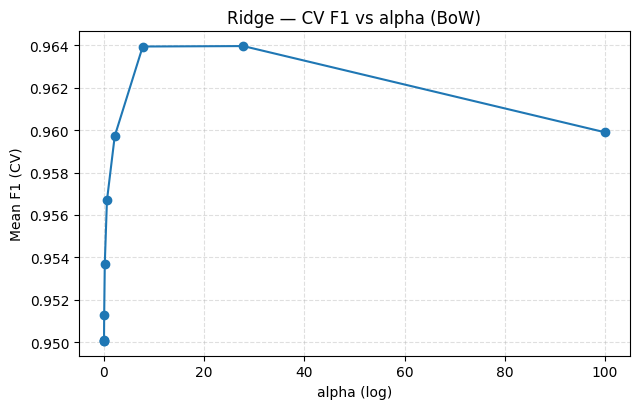

✅ Ridge (BoW) — best alpha: 27.83


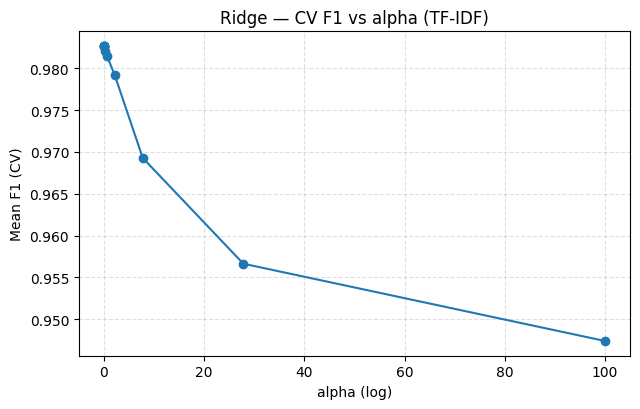

✅ Ridge (TF-IDF) — best alpha: 0.001


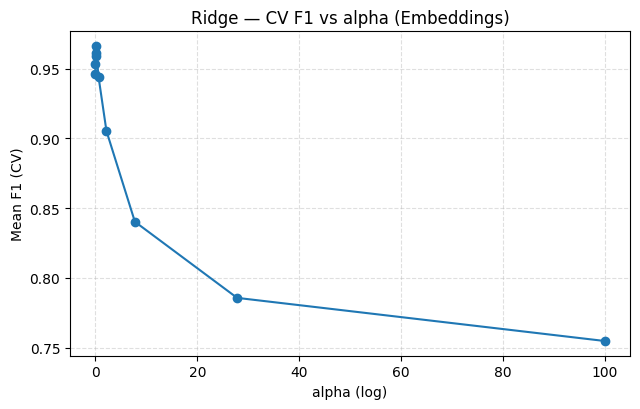

✅ Ridge (Emb) — best alpha: 0.04642


In [57]:
# # ===== 6) RidgeClassifier — chọn alpha theo từng biểu diễn =====
# def tune_alpha_ridge(Xtr, ytr, title_suffix=""):
#     alphas = np.logspace(-3, 2, 10)  # 1e-3..1e2
#     means = []
#     for a in alphas:
#         clf = RidgeClassifier(alpha=a, class_weight='balanced', random_state=42)
#         s = cross_val_score(clf, Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1)
#         means.append(s.mean())
#     plot_cv_curve(alphas, means, "alpha (log)", f"Ridge — CV F1 vs alpha {title_suffix}")
#     return float(alphas[int(np.argmax(means))])

# # BoW
# best_ridge_alpha_bow = tune_alpha_ridge(X_train_bow_bal, y_train_bow_bal, "(BoW)")
# ridge_bow = RidgeClassifier(alpha=best_ridge_alpha_bow, class_weight='balanced', random_state=42)
# ridge_bow.fit(X_train_bow_bal, y_train_bow_bal)
# ridge_bow_labels = ridge_bow.predict(X_test_bow)
# print(f"✅ Ridge (BoW) — best alpha: {best_ridge_alpha_bow:.4g}")

# # TF-IDF
# best_ridge_alpha_tfidf = tune_alpha_ridge(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
# ridge_tfidf = RidgeClassifier(alpha=best_ridge_alpha_tfidf, class_weight='balanced', random_state=42)
# ridge_tfidf.fit(X_train_tfidf_bal, y_train_tfidf_bal)
# ridge_tfidf_labels = ridge_tfidf.predict(X_test_tfidf)
# print(f"✅ Ridge (TF-IDF) — best alpha: {best_ridge_alpha_tfidf:.4g}")

# # Embeddings
# best_ridge_alpha_emb = tune_alpha_ridge(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
# ridge_emb = RidgeClassifier(alpha=best_ridge_alpha_emb, class_weight='balanced', random_state=42)
# ridge_emb.fit(X_train_emb_bal, y_train_emb_bal)
# ridge_emb_labels = ridge_emb.predict(X_test_embeddings)
# print(f"✅ Ridge (Emb) — best alpha: {best_ridge_alpha_emb:.4g}")


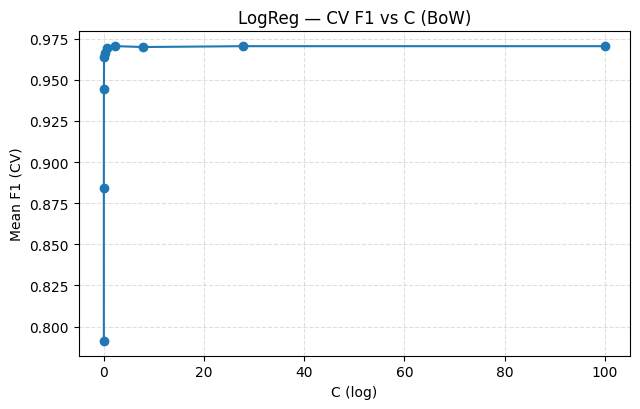

✅ LogReg (BoW) — best C: 2.154


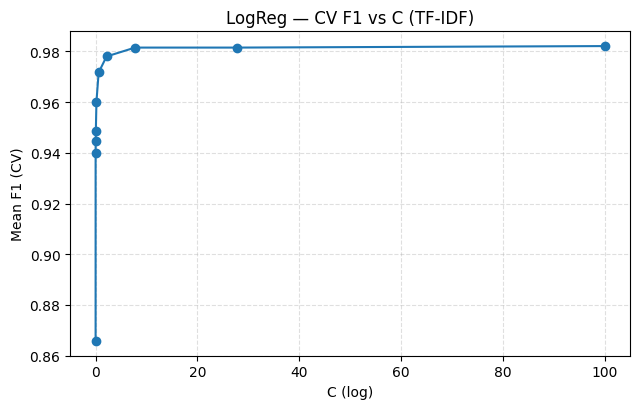

✅ LogReg (TF-IDF) — best C: 100


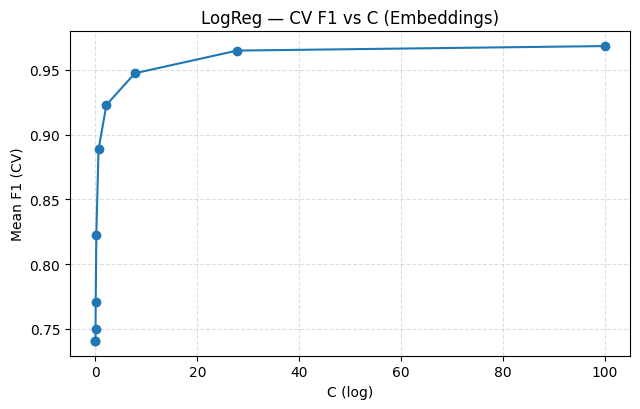

✅ LogReg (Emb) — best C: 100


In [58]:
# # ===== 7) Logistic Regression — chọn C theo từng biểu diễn =====
# def tune_C_logreg(Xtr, ytr, title_suffix=""):
#     Cs = np.logspace(-3, 2, 10)
#     means = []
#     for C in Cs:
#         # 'saga' hỗ trợ sparse + multiclass, phù hợp cho BoW/TF-IDF; ổn cho dense embeddings
#         clf = LogisticRegression(C=C, penalty='l2', solver='saga',
#                                  max_iter=3000, class_weight='balanced',
#                                  random_state=42, n_jobs=-1)
#         s = cross_val_score(clf, Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1)
#         means.append(s.mean())
#     plot_cv_curve(Cs, means, "C (log)", f"LogReg — CV F1 vs C {title_suffix}")
#     return float(Cs[int(np.argmax(means))])

# # BoW
# best_logreg_C_bow = tune_C_logreg(X_train_bow_bal, y_train_bow_bal, "(BoW)")
# log_bow = LogisticRegression(C=best_logreg_C_bow, penalty='l2', solver='saga',
#                              max_iter=3000, class_weight='balanced',
#                              random_state=42, n_jobs=-1)
# log_bow.fit(X_train_bow_bal, y_train_bow_bal)
# log_bow_labels = log_bow.predict(X_test_bow)
# print(f"✅ LogReg (BoW) — best C: {best_logreg_C_bow:.4g}")

# # TF-IDF
# best_logreg_C_tfidf = tune_C_logreg(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
# log_tfidf = LogisticRegression(C=best_logreg_C_tfidf, penalty='l2', solver='saga',
#                                max_iter=3000, class_weight='balanced',
#                                random_state=42, n_jobs=-1)
# log_tfidf.fit(X_train_tfidf_bal, y_train_tfidf_bal)
# log_tfidf_labels = log_tfidf.predict(X_test_tfidf)
# print(f"✅ LogReg (TF-IDF) — best C: {best_logreg_C_tfidf:.4g}")

# # Embeddings
# best_logreg_C_emb = tune_C_logreg(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
# log_emb = LogisticRegression(C=best_logreg_C_emb, penalty='l2', solver='saga',
#                              max_iter=3000, class_weight='balanced',
#                              random_state=42, n_jobs=-1)
# log_emb.fit(X_train_emb_bal, y_train_emb_bal)
# log_emb_labels = log_emb.predict(X_test_embeddings)
# print(f"✅ LogReg (Emb) — best C: {best_logreg_C_emb:.4g}")


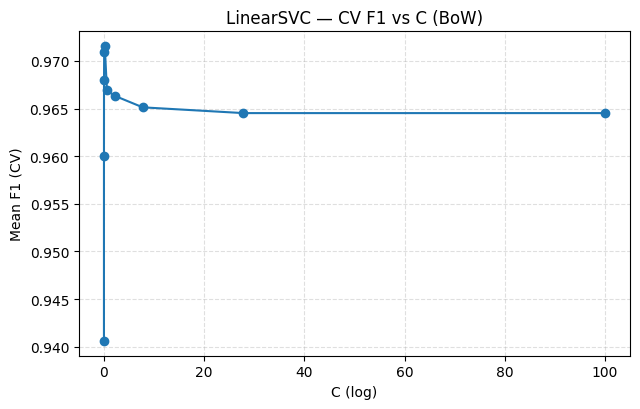

✅ LinearSVC (BoW) — best C: 0.1668


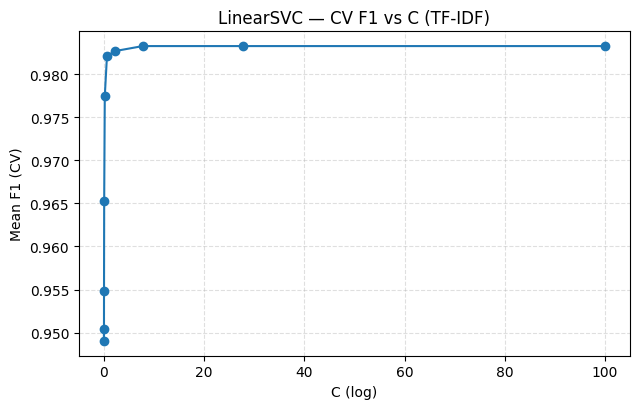

✅ LinearSVC (TF-IDF) — best C: 7.743


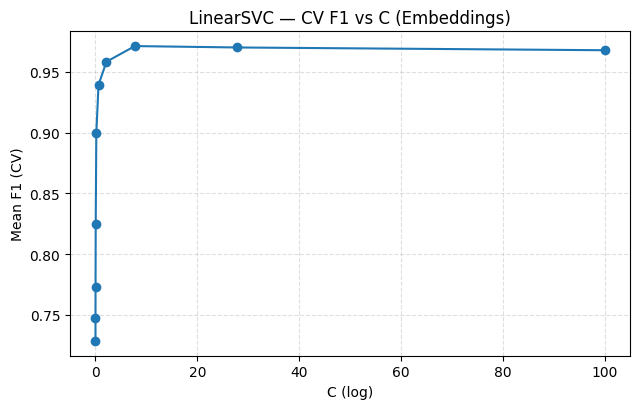

✅ LinearSVC (Emb) — best C: 7.743


In [39]:
# # ===== 8) LinearSVC — chọn C theo từng biểu diễn =====
# def tune_C_linsvc(Xtr, ytr, title_suffix=""):
#     Cs = np.logspace(-3, 2, 10)
#     means = []
#     for C in Cs:
#         clf = LinearSVC(C=C, class_weight='balanced', random_state=42)
#         s = cross_val_score(clf, Xtr, ytr, cv=cv, scoring=f1_scorer, n_jobs=-1)
#         means.append(s.mean())
#     plot_cv_curve(Cs, means, "C (log)", f"LinearSVC — CV F1 vs C {title_suffix}")
#     return float(Cs[int(np.argmax(means))])

# # BoW
# best_lsvc_C_bow = tune_C_linsvc(X_train_bow_bal, y_train_bow_bal, "(BoW)")
# svc_bow = LinearSVC(C=best_lsvc_C_bow, class_weight='balanced', random_state=42)
# svc_bow.fit(X_train_bow_bal, y_train_bow_bal)
# svc_bow_labels = svc_bow.predict(X_test_bow)
# print(f"✅ LinearSVC (BoW) — best C: {best_lsvc_C_bow:.4g}")

# # TF-IDF
# best_lsvc_C_tfidf = tune_C_linsvc(X_train_tfidf_bal, y_train_tfidf_bal, "(TF-IDF)")
# svc_tfidf = LinearSVC(C=best_lsvc_C_tfidf, class_weight='balanced', random_state=42)
# svc_tfidf.fit(X_train_tfidf_bal, y_train_tfidf_bal)
# svc_tfidf_labels = svc_tfidf.predict(X_test_tfidf)
# print(f"✅ LinearSVC (TF-IDF) — best C: {best_lsvc_C_tfidf:.4g}")

# # Embeddings
# best_lsvc_C_emb = tune_C_linsvc(X_train_emb_bal, y_train_emb_bal, "(Embeddings)")
# svc_emb = LinearSVC(C=best_lsvc_C_emb, class_weight='balanced', random_state=42)
# svc_emb.fit(X_train_emb_bal, y_train_emb_bal)
# svc_emb_labels = svc_emb.predict(X_test_embeddings)
# print(f"✅ LinearSVC (Emb) — best C: {best_lsvc_C_emb:.4g}")


,Model,Feature,BestParam,BestCV_F1
0,GaussianNB,BoW,var_smoothing=1.00e-12,0.978673
1,GaussianNB,Embeddings,var_smoothing=1.00e-12,0.884064
2,GaussianNB,TF-IDF,var_smoothing=1.00e-12,0.978078
3,LinearSVC,BoW,C=0.1668,0.971558
4,LinearSVC,Embeddings,C=7.743,0.971265
5,LinearSVC,TF-IDF,C=7.743,0.983256
6,LogReg,BoW,C=2.154,0.970456
7,LogReg,Embeddings,C=100,0.968384
8,LogReg,TF-IDF,C=100,0.982085
9,Ridge,BoW,alpha=27.83,0.963967


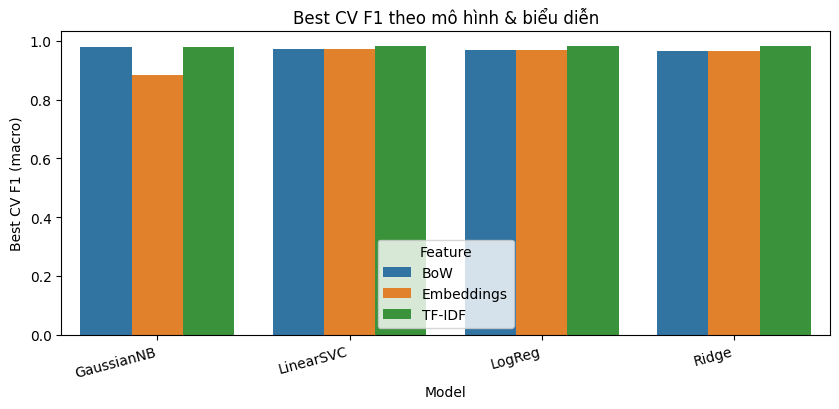

🏆 Best among linear family (CV): LinearSVC | Feature=TF-IDF | C=7.743 | F1=0.9833


In [72]:
# ====== 9) Tổng hợp kết quả & mô hình tốt nhất mỗi nhóm ======
def cv_f1(est, X, y): return cross_val_score(est, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1).mean()

rows = []
def add_row(model_name, feature, param_str, estimator, Xtr, ytr):
    if estimator is None or Xtr is None: return
    rows.append({"Model": model_name, "Feature": feature, "BestParam": param_str,
                 "BestCV_F1": cv_f1(estimator, Xtr, ytr)})

# KNN (nếu có best_k_* trong globals)
def _knn_row(best_k, feat_name, Xtr, ytr):
    if best_k is None or Xtr is None: return
    add_row("KNN", feat_name, f"k={best_k}", KNeighborsClassifier(n_neighbors=int(best_k)), Xtr, ytr)

_knn_row(globals().get("best_k_knn_bow"),   "BoW",        globals().get("X_train_bow_bal"),   globals().get("y_train_bow_bal"))
_knn_row(globals().get("best_k_knn_tfidf"), "TF-IDF",     globals().get("X_train_tfidf_bal"), globals().get("y_train_tfidf_bal"))
_knn_row(globals().get("best_k_knn_emb"),   "Embeddings", globals().get("X_train_emb_bal"),   globals().get("y_train_emb_bal"))

# GaussianNB
def _nb_row(best_vs, feat_name, Xtr, ytr):
    if best_vs is None or Xtr is None: return
    Xtr2 = _to_dense(Xtr)
    add_row("GaussianNB", feat_name, f"var_smoothing={best_vs:.2e}", GaussianNB(var_smoothing=float(best_vs)), Xtr2, ytr)

_nb_row(globals().get("best_nb_vs_bow", best_nb_vs if 'best_nb_vs' in globals() else None), "BoW",        globals().get("X_train_bow_bal"),   globals().get("y_train_bow_bal"))
_nb_row(globals().get("best_nb_vs_tfidf", globals().get("best_nb_vs", None)),               "TF-IDF",     globals().get("X_train_tfidf_bal"), globals().get("y_train_tfidf_bal"))
_nb_row(globals().get("best_nb_vs_emb", globals().get("best_nb_vs", None)),                 "Embeddings", globals().get("X_train_emb_bal"),   globals().get("y_train_emb_bal"))

# Ridge / LogReg / LinearSVC
add_row("Ridge", "BoW",        f"alpha={best_ridge_alpha_bow:.4g}",   RidgeClassifier(alpha=float(best_ridge_alpha_bow), class_weight='balanced', random_state=SEED), X_train_bow_bal,   y_train_bow_bal)
add_row("Ridge", "TF-IDF",     f"alpha={best_ridge_alpha_tfidf:.4g}", RidgeClassifier(alpha=float(best_ridge_alpha_tfidf), class_weight='balanced', random_state=SEED), X_train_tfidf_bal, y_train_tfidf_bal)
add_row("Ridge", "Embeddings", f"alpha={best_ridge_alpha_emb:.4g}",   RidgeClassifier(alpha=float(best_ridge_alpha_emb), class_weight='balanced', random_state=SEED), X_train_emb_bal,   y_train_emb_bal)

add_row("LogReg", "BoW",        f"C={best_logreg_C_bow:.4g}",   LogisticRegression(C=float(best_logreg_C_bow), penalty='l2', solver='saga', max_iter=3000, class_weight='balanced', random_state=SEED, n_jobs=-1), X_train_bow_bal,   y_train_bow_bal)
add_row("LogReg", "TF-IDF",     f"C={best_logreg_C_tfidf:.4g}", LogisticRegression(C=float(best_logreg_C_tfidf), penalty='l2', solver='saga', max_iter=3000, class_weight='balanced', random_state=SEED, n_jobs=-1), X_train_tfidf_bal, y_train_tfidf_bal)
add_row("LogReg", "Embeddings", f"C={best_logreg_C_emb:.4g}",   LogisticRegression(C=float(best_logreg_C_emb), penalty='l2', solver='saga', max_iter=3000, class_weight='balanced', random_state=SEED, n_jobs=-1), X_train_emb_bal,   y_train_emb_bal)

add_row("LinearSVC", "BoW",        f"C={best_lsvc_C_bow:.4g}",   LinearSVC(C=float(best_lsvc_C_bow), class_weight='balanced', random_state=SEED), X_train_bow_bal,   y_train_bow_bal)
add_row("LinearSVC", "TF-IDF",     f"C={best_lsvc_C_tfidf:.4g}", LinearSVC(C=float(best_lsvc_C_tfidf), class_weight='balanced', random_state=SEED), X_train_tfidf_bal, y_train_tfidf_bal)
add_row("LinearSVC", "Embeddings", f"C={best_lsvc_C_emb:.4g}",   LinearSVC(C=float(best_lsvc_C_emb), class_weight='balanced', random_state=SEED), X_train_emb_bal,   y_train_emb_bal)

summary = pd.DataFrame(rows).sort_values(by=["Model","Feature"]).reset_index(drop=True)
display(summary)

plt.figure(figsize=(8.5, 4.2))
bar_df = summary.dropna(subset=["BestCV_F1"]).copy()
sns.barplot(data=bar_df, x="Model", y="BestCV_F1", hue="Feature")
plt.xticks(rotation=15, ha='right'); plt.ylabel('Best CV F1 (macro)')
plt.title('Best CV F1 theo mô hình & biểu diễn'); plt.tight_layout(); plt.show()

linear_df = bar_df[bar_df["Model"].isin(["Ridge","LogReg","LinearSVC"])].copy()
if not linear_df.empty:
    best_row = linear_df.iloc[linear_df["BestCV_F1"].argmax()]
    print(f"🏆 Best among linear family (CV): {best_row['Model']} | Feature={best_row['Feature']} | {best_row['BestParam']} | F1={best_row['BestCV_F1']:.4f}")
else:
    print("⚠️ Không có kết quả nhóm linear để tổng hợp.")

In [73]:
# ===== 3) Bảng tóm tắt nhanh =====
rows = []
rows += [_summarize("KNN — BoW",         y_test, knn_bow_labels)]
rows += [_summarize("KNN — TF-IDF",      y_test, knn_tfidf_labels)]
rows += [_summarize("KNN — Embeddings",  y_test, knn_emb_labels)]

rows += [_summarize("Decision Tree — BoW",        y_test, dt_bow_labels)]
rows += [_summarize("Decision Tree — TF-IDF",     y_test, dt_tfidf_labels)]
rows += [_summarize("Decision Tree — Embeddings", y_test, dt_emb_labels)]

rows += [_summarize("Naive Bayes — BoW",         y_test, nb_bow_labels)]
rows += [_summarize("Naive Bayes — TF-IDF",      y_test, nb_tfidf_labels)]
rows += [_summarize("Naive Bayes — Embeddings",  y_test, nb_emb_labels)]

rows += [_summarize("LinearSVC — BoW",        y_test, svc_bow_labels)]
rows += [_summarize("LinearSVC — TF-IDF",     y_test, svc_tfidf_labels)]
rows += [_summarize("LinearSVC — Embeddings", y_test, svc_emb_labels)]

rows += [_summarize("LogReg — BoW",        y_test, log_bow_labels)]
rows += [_summarize("LogReg — TF-IDF",     y_test, log_tfidf_labels)]
rows += [_summarize("LogReg — Embeddings", y_test, log_emb_labels)]

rows += [_summarize("Ridge — BoW",        y_test, ridge_bow_labels)]
rows += [_summarize("Ridge — TF-IDF",     y_test, ridge_tfidf_labels)]
rows += [_summarize("Ridge — Embeddings", y_test, ridge_emb_labels)]

results_df_all = pd.DataFrame(rows).sort_values(["f1_macro","accuracy"], ascending=False).reset_index(drop=True)
print("\n🏁 Tổng hợp (top 10 theo F1-macro):")
display(results_df_all.head(10))
best = results_df_all.iloc[0]
print(f"🏆 Best: {best['model_feature']} | Acc={best['accuracy']:.4f} | F1-macro={best['f1_macro']:.4f}")


🏁 Tổng hợp (top 10 theo F1-macro):


,model_feature,accuracy,f1_macro,f1_weighted
0,Ridge — Embeddings,0.920,0.824190,0.915303
1,LinearSVC — Embeddings,0.915,0.785925,0.909964
2,LogReg — Embeddings,0.900,0.726147,0.891314
3,KNN — Embeddings,0.895,0.712250,0.880666
4,Naive Bayes — Embeddings,0.885,0.707016,0.873674
5,Naive Bayes — BoW,0.905,0.670459,0.881452
6,Naive Bayes — TF-IDF,0.900,0.669934,0.879855
7,Ridge — TF-IDF,0.895,0.665512,0.875052
8,LinearSVC — TF-IDF,0.895,0.655015,0.873433
9,LogReg — TF-IDF,0.895,0.654272,0.873710


🏆 Best: Ridge — Embeddings | Acc=0.9200 | F1-macro=0.8242


# **6. Tổng hợp kết quả + Vẽ tất cả mô hình**

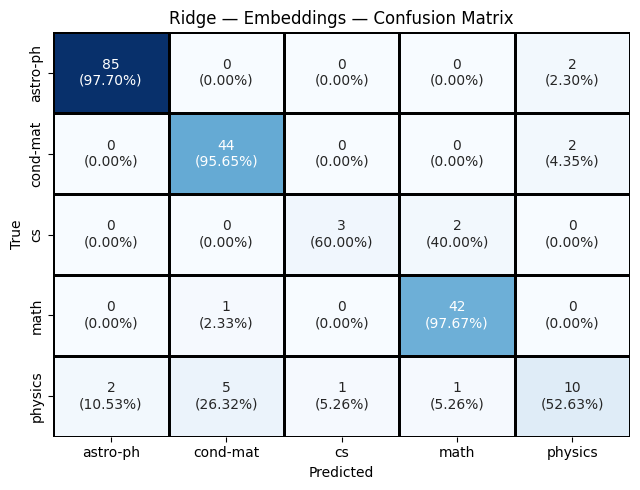

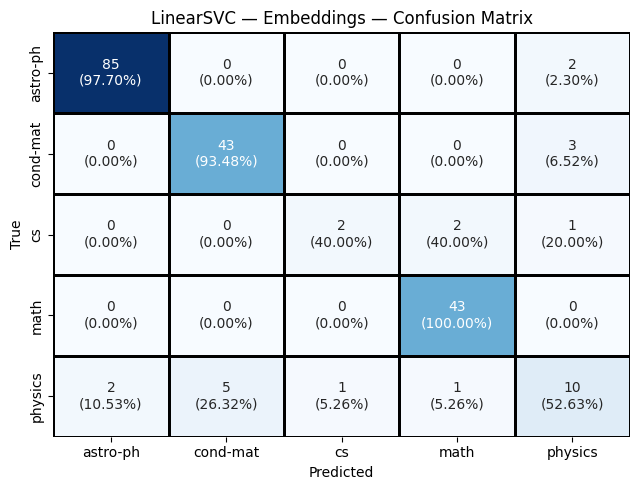

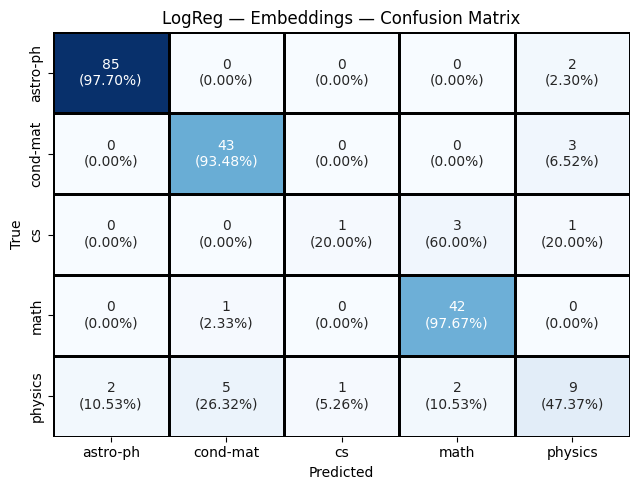

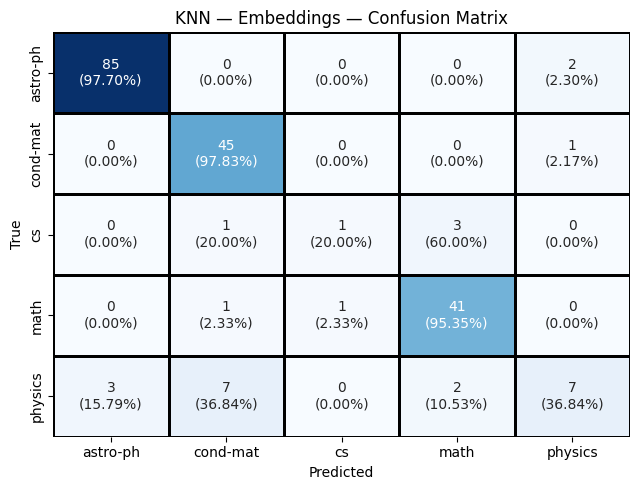

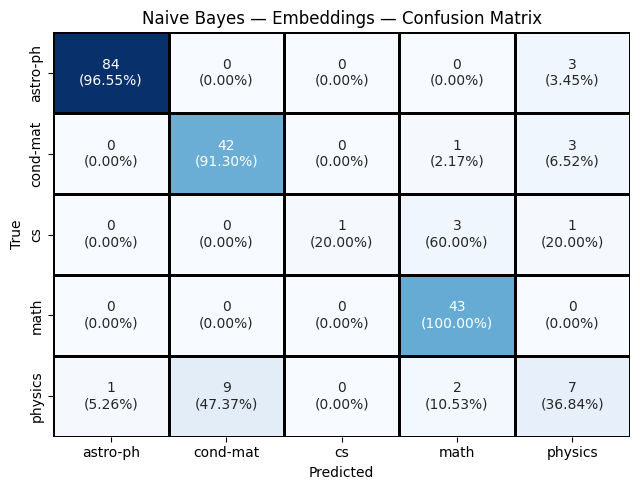

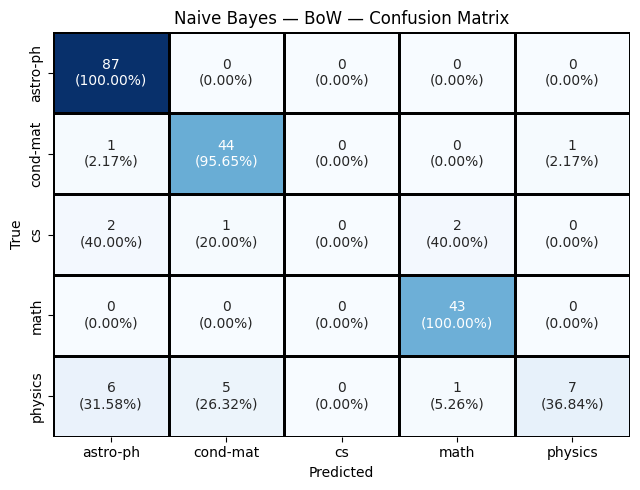

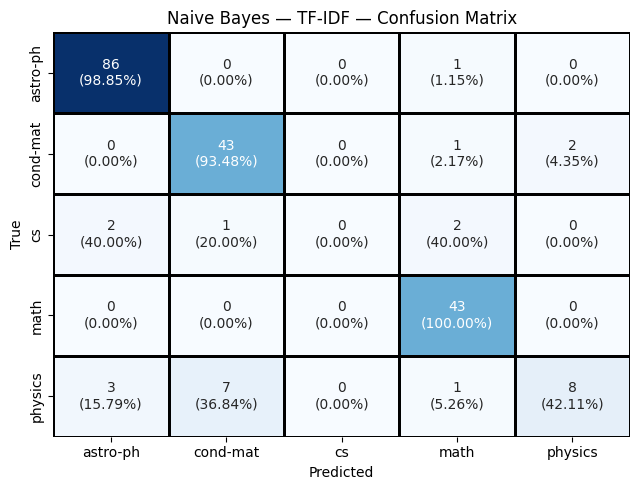

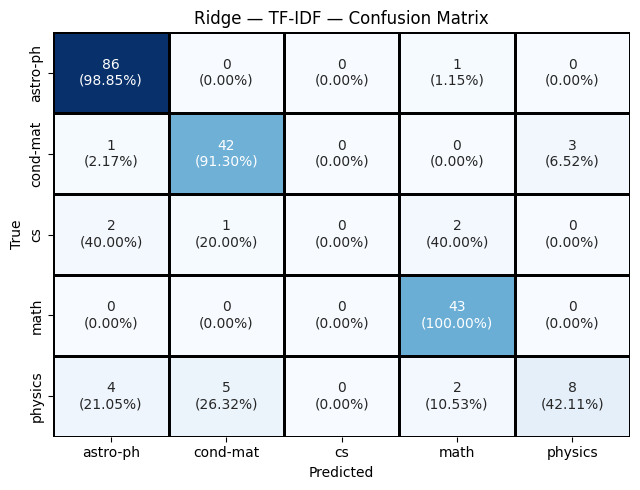

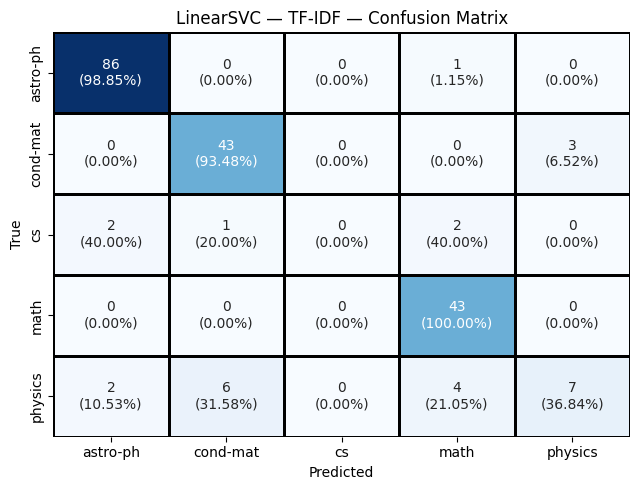

🏆 Top: Ridge — Embeddings | Acc=0.9200 | F1-macro=0.8242
📁 Confusion Matrix đã lưu:
 - pdf/Figures/all_models (tất cả mô hình)
 - pdf/Figures/balanced (so sánh cân bằng)
💾 Đã lưu: all_models_metrics.csv


In [74]:
def _cm_annot(cm: np.ndarray) -> np.ndarray:
    cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    ann = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ann[i, j] = f"{cm[i, j]}\n({cmn[i, j]:.2%})"
    return ann

def _save_cm(y_true, y_pred, title, save_dir, fname_stub, show=True):
    cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
    ann = _cm_annot(cm)
    plt.figure(figsize=(6.5, 5))
    sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
                xticklabels=sorted_labels, yticklabels=sorted_labels,
                cbar=False, linewidths=1, linecolor='black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout()
    fn = re.sub(r"[^a-zA-Z0-9\-_.]+", "_", fname_stub) + "_cm.pdf"
    path = os.path.join(PATHS.all_models, fn)
    plt.savefig(path, bbox_inches="tight")
    if show: plt.show()
    else:    plt.close()

SHOW_TOP_N = 9
pred_map = {
    "KNN — BoW": knn_bow_labels, "KNN — TF-IDF": knn_tfidf_labels, "KNN — Embeddings": knn_emb_labels,
    "Decision Tree — BoW": dt_bow_labels, "Decision Tree — TF-IDF": dt_tfidf_labels, "Decision Tree — Embeddings": dt_emb_labels,
    "Naive Bayes — BoW": nb_bow_labels, "Naive Bayes — TF-IDF": nb_tfidf_labels, "Naive Bayes — Embeddings": nb_emb_labels,
    "LinearSVC — BoW": svc_bow_labels, "LinearSVC — TF-IDF": svc_tfidf_labels, "LinearSVC — Embeddings": svc_emb_labels,
    "LogReg — BoW": log_bow_labels, "LogReg — TF-IDF": log_tfidf_labels, "LogReg — Embeddings": log_emb_labels,
    "Ridge — BoW": ridge_bow_labels, "Ridge — TF-IDF": ridge_tfidf_labels, "Ridge — Embeddings": ridge_emb_labels,
}
order_names = results_df_all["model_feature"].tolist()
for i, name in enumerate(order_names):
    _save_cm(y_test, pred_map[name], title=f"{name} — Confusion Matrix",
             save_dir=PATHS.all_models, fname_stub=name, show=(i < SHOW_TOP_N))

# (Tuỳ chọn) So sánh trước/sau cân bằng nếu có biến *_pre
def plot_confusion_single(y_true, y_pred, class_names=None, title="", save_path=None):
    class_names = class_names or sorted_labels
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    ann = _cm_annot(cm)
    plt.figure(figsize=(6.5, 5))
    sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def compare_confusions(y_true, y_pred_pre, y_pred_post, class_names=None,
                       title_pre="Trước cân bằng", title_post="Sau cân bằng", save_path=None):
    class_names = class_names or sorted_labels
    labels = range(len(class_names))
    cm_pre  = confusion_matrix(y_true, y_pred_pre,  labels=labels)
    cm_post = confusion_matrix(y_true, y_pred_post, labels=labels)
    ann_pre, ann_post = _cm_annot(cm_pre), _cm_annot(cm_post)
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)
    sns.heatmap(cm_pre,  annot=ann_pre,  fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black', ax=axes[0])
    axes[0].set_title(title_pre); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
    sns.heatmap(cm_post, annot=ann_post, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=1, linecolor='black', ax=axes[1])
    axes[1].set_title(title_post); axes[1].set_xlabel("Predicted")
    plt.tight_layout()
    if save_path: plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# Ví dụ dùng (nếu có *_pre trong globals):
# if 'knn_bow_labels_pre' in globals():
#     compare_confusions(y_test, knn_bow_labels_pre, knn_bow_labels,
#                        sorted_labels, "KNN-BoW (trước cân bằng)", "KNN-BoW (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "knn_bow_compare.pdf"))

# ==== Lưu CSV & kết luận nhanh ====
csv_path = "all_models_metrics.csv"
results_df_all.to_csv(csv_path, index=False)
lead = results_df_all.iloc[0]
print(f"🏆 Top: {lead['model_feature']} | Acc={lead['accuracy']:.4f} | F1-macro={lead['f1_macro']:.4f}")
print(f"📁 Confusion Matrix đã lưu:\n - {PATHS.all_models} (tất cả mô hình)\n - {PATHS.balanced} (so sánh cân bằng)")
print(f"💾 Đã lưu: {csv_path}")

🏁 Bảng tổng hợp (top 12 theo F1-macro):


,model_feature,algo,repr,accuracy,f1_macro,f1_weighted
0,Ridge — Embeddings,Ridge,Embeddings,0.920,0.824190,0.915303
1,LinearSVC — Embeddings,LinearSVC,Embeddings,0.915,0.785925,0.909964
2,LogReg — Embeddings,LogReg,Embeddings,0.900,0.726147,0.891314
3,KNN — Embeddings,KNN,Embeddings,0.895,0.712250,0.880666
4,Naive Bayes — Embeddings,Naive Bayes,Embeddings,0.885,0.707016,0.873674
5,Naive Bayes — BoW,Naive Bayes,BoW,0.905,0.670459,0.881452
6,Naive Bayes — TF-IDF,Naive Bayes,TF-IDF,0.900,0.669934,0.879855
7,Ridge — TF-IDF,Ridge,TF-IDF,0.895,0.665512,0.875052
8,LinearSVC — TF-IDF,LinearSVC,TF-IDF,0.895,0.655015,0.873433
9,LogReg — TF-IDF,LogReg,TF-IDF,0.895,0.654272,0.873710


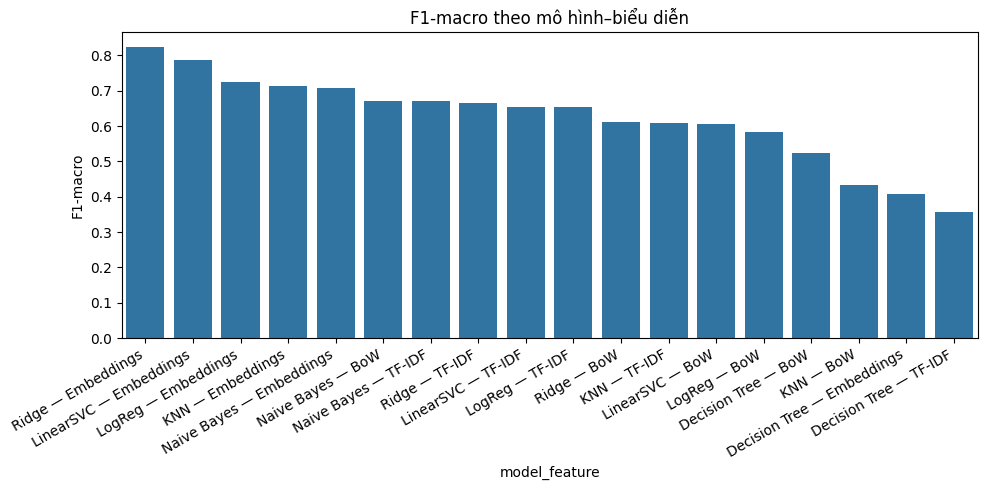

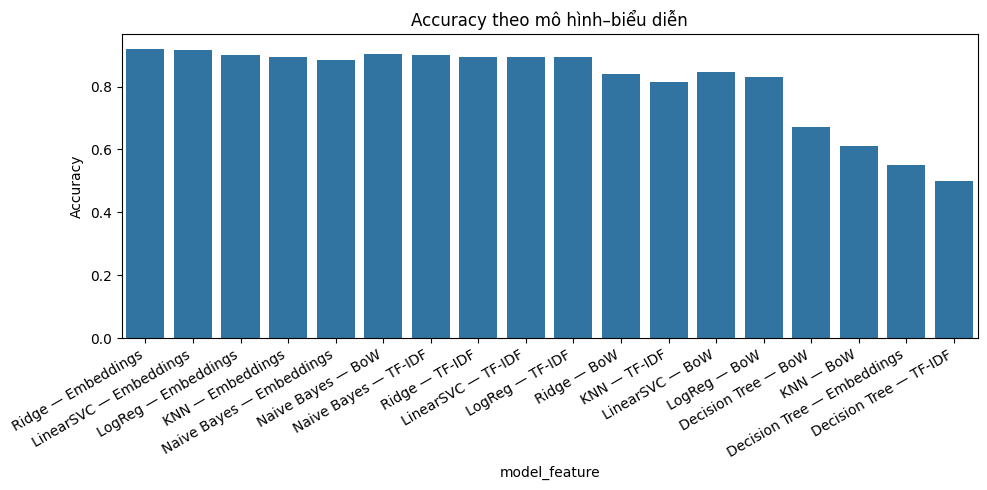

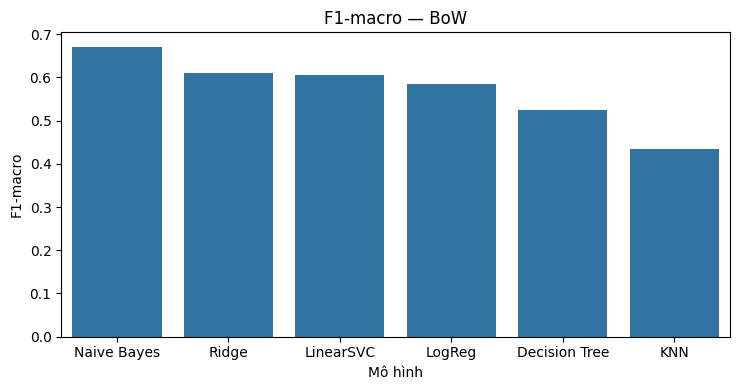

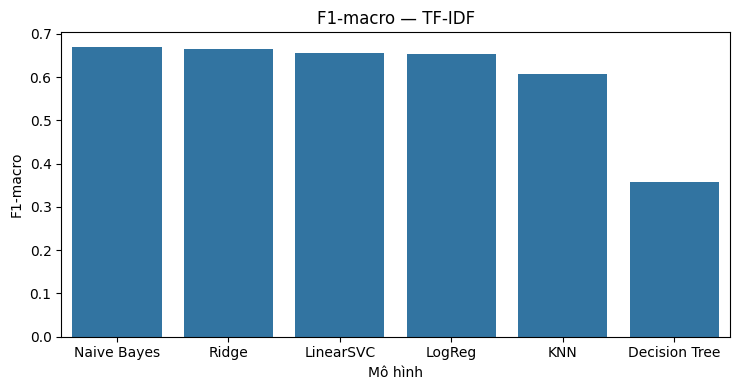

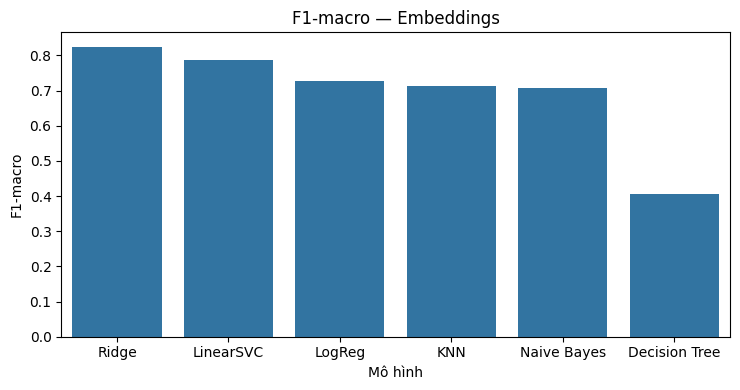

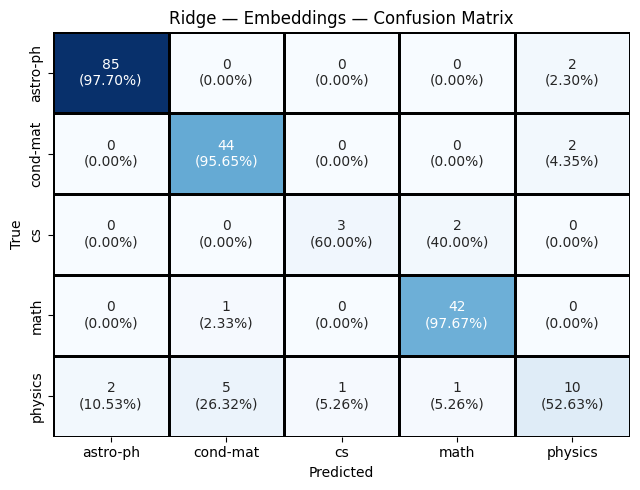

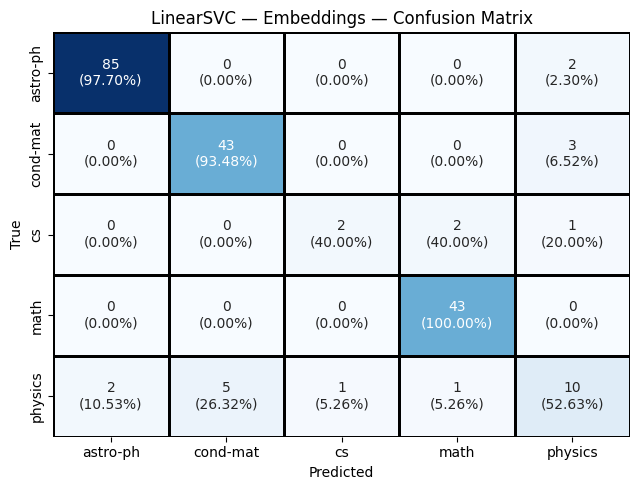

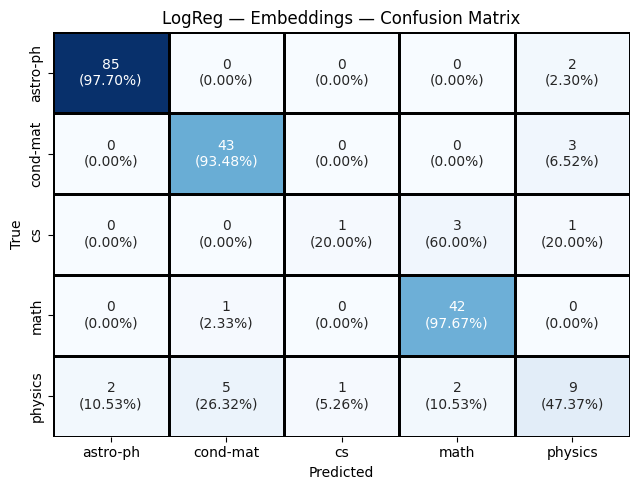

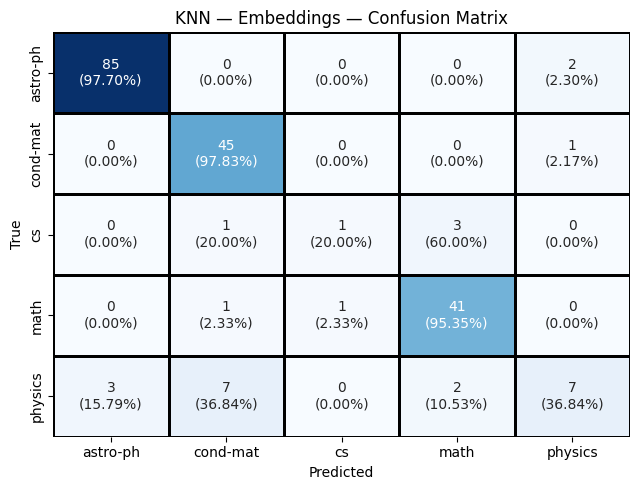

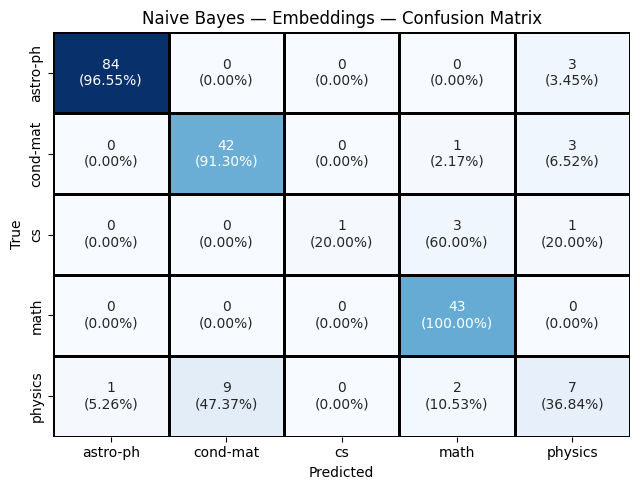

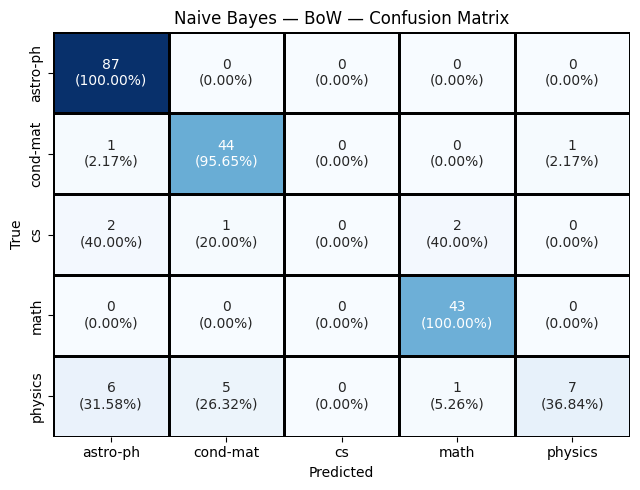

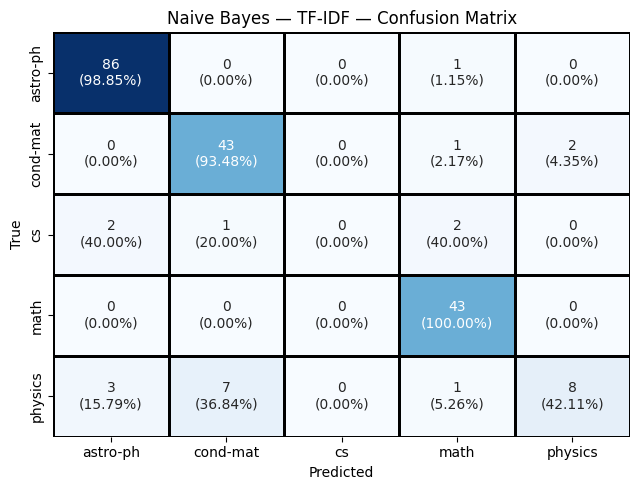

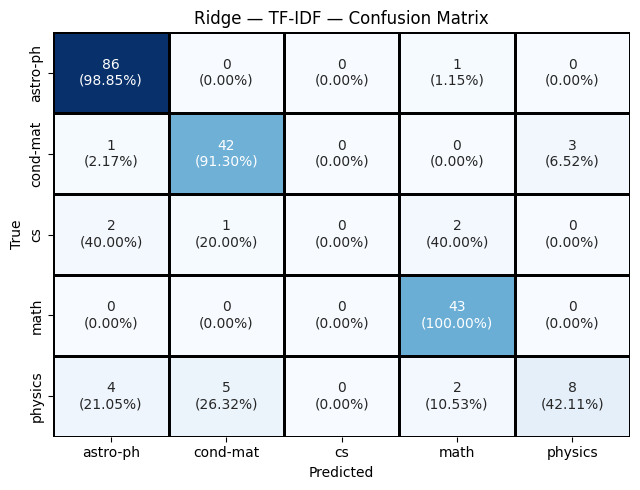

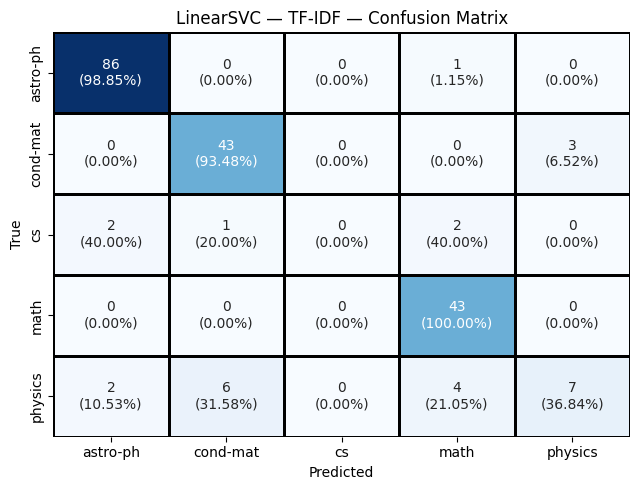

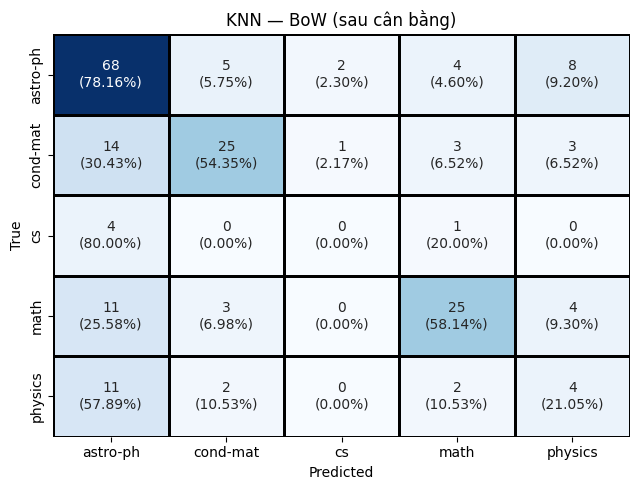

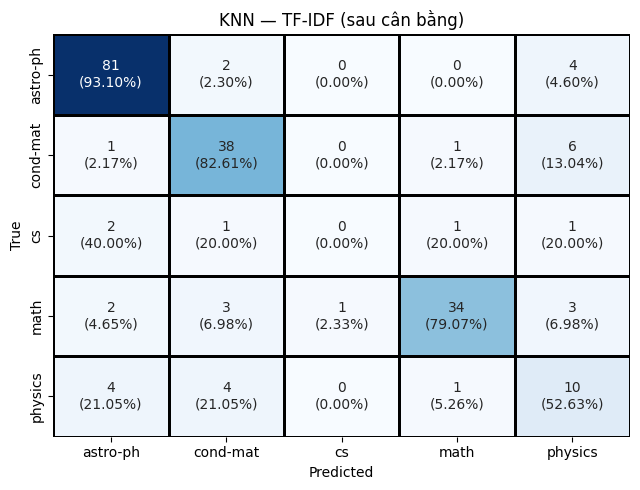

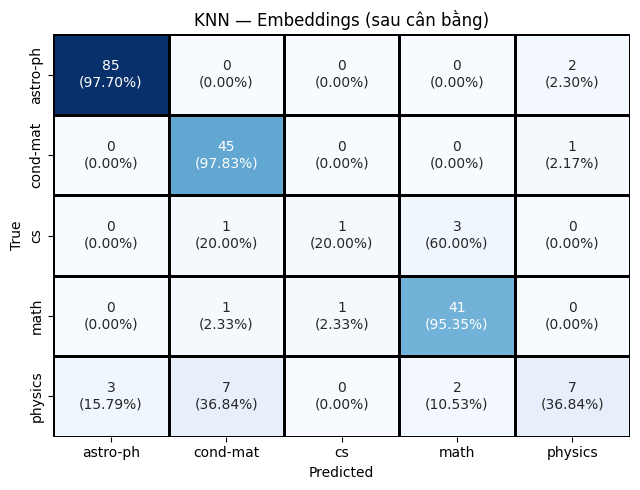

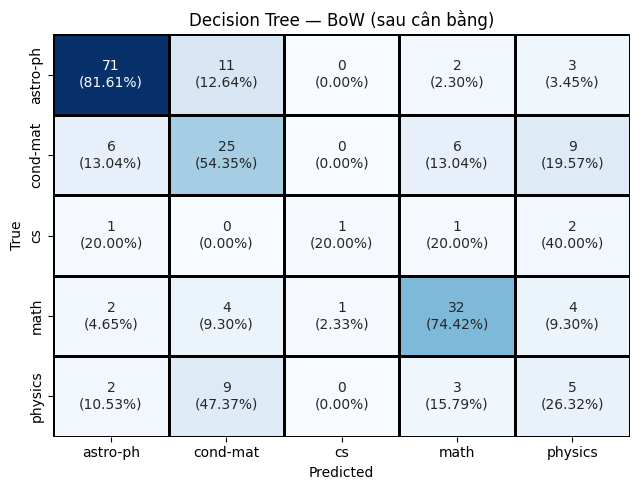

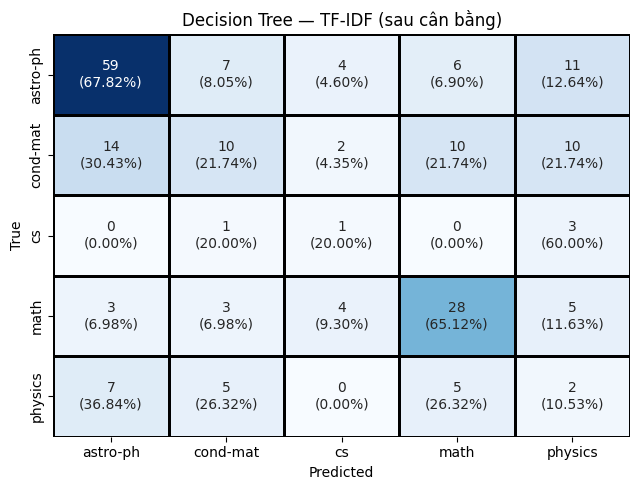

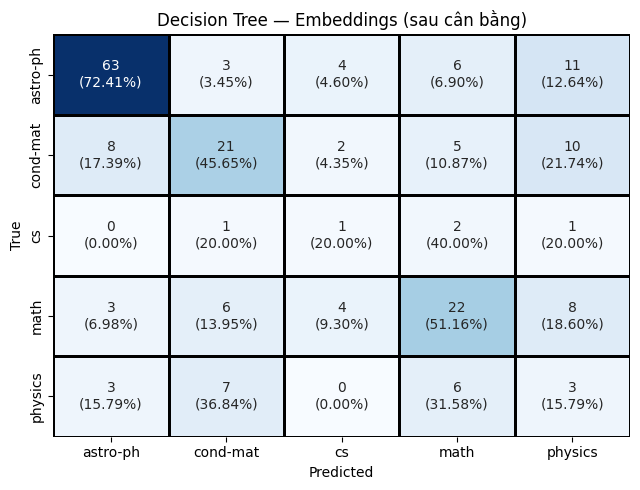

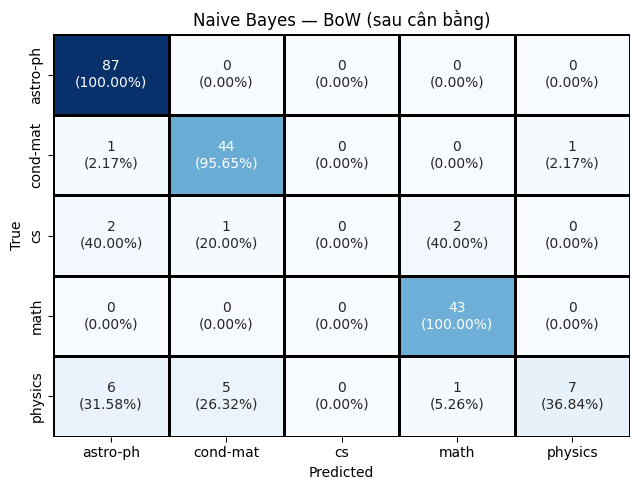

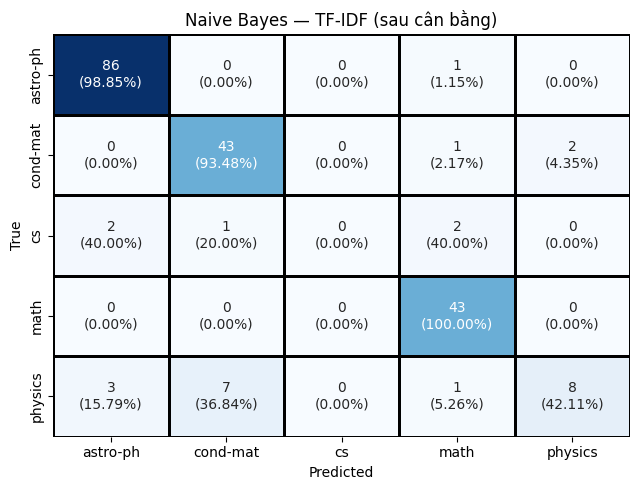

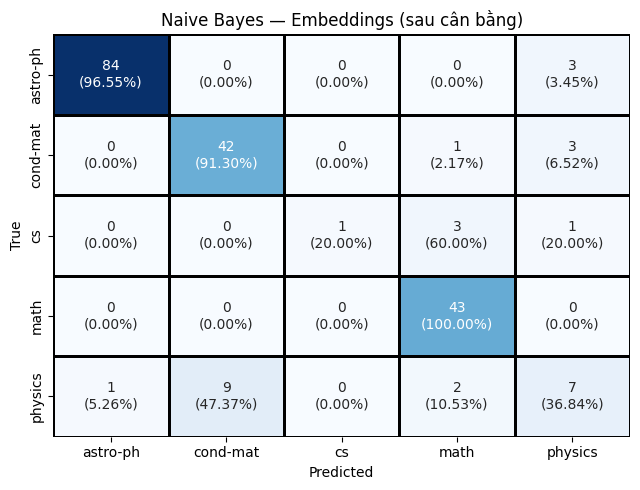

🏆 Top: Ridge — Embeddings | Acc=0.9200 | F1-macro=0.8242
📁 Confusion Matrix đã lưu vào:
 - pdf/Figures/all_models (tất cả mô hình)
 - pdf/Figures/balanced (so sánh cân bằng)
💾 Đã lưu: all_models_metrics.csv


In [43]:
# # ---- Chuẩn bị nhãn hiển thị ----
# assert 'y_test' in globals(), "Cần có y_test từ bước split dữ liệu."
# if 'sorted_labels' not in globals():
#     uniq = sorted(set(y_test))
#     sorted_labels = [str(i) for i in uniq]
# labels_idx = list(range(len(sorted_labels)))

# # ---- Helper vẽ Confusion (tạo nếu chưa có) ----
# def _cm_annot(cm: np.ndarray) -> np.ndarray:
#     cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
#     ann = np.empty_like(cm).astype(str)
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ann[i, j] = f"{cm[i, j]}\n({cmn[i, j]:.2%})"
#     return ann


# # 1) Thu thập dự đoán mọi mô hình
# ALL_CANDIDATES = [
#     # KNN
#     ("KNN — BoW", "knn_bow_labels"),
#     ("KNN — TF-IDF", "knn_tfidf_labels"),
#     ("KNN — Embeddings", "knn_emb_labels"),
#     # Decision Tree
#     ("Decision Tree — BoW", "dt_bow_labels"),
#     ("Decision Tree — TF-IDF", "dt_tfidf_labels"),
#     ("Decision Tree — Embeddings", "dt_emb_labels"),
#     # Naive Bayes
#     ("Naive Bayes — BoW", "nb_bow_labels"),
#     ("Naive Bayes — TF-IDF", "nb_tfidf_labels"),
#     ("Naive Bayes — Embeddings", "nb_emb_labels"),
#     # LinearSVC
#     ("LinearSVC — BoW", "svc_bow_labels"),
#     ("LinearSVC — TF-IDF", "svc_tfidf_labels"),
#     ("LinearSVC — Embeddings", "svc_emb_labels"),
#     # Logistic Regression
#     ("LogReg — BoW", "log_bow_labels"),
#     ("LogReg — TF-IDF", "log_tfidf_labels"),
#     ("LogReg — Embeddings", "log_emb_labels"),
#     # Ridge
#     ("Ridge — BoW", "ridge_bow_labels"),
#     ("Ridge — TF-IDF", "ridge_tfidf_labels"),
#     ("Ridge — Embeddings", "ridge_emb_labels"),
# ]

# pred_map = {}
# missing = []
# for disp, var in ALL_CANDIDATES:
#     if var in globals():
#         pred_map[disp] = globals()[var]
#     else:
#         missing.append(disp)

# if not pred_map:
#     raise RuntimeError("Không tìm thấy biến dự đoán nào. Hãy chạy cell huấn luyện để tạo các *_labels trước.")

# if missing:
#     print("ℹ️ Chưa có dự đoán cho:", ", ".join(missing))

# # 2) Bảng tổng hợp metrics
# rows = []
# for name, y_pred in pred_map.items():
#     acc = accuracy_score(y_test, y_pred)
#     f1m = f1_score(y_test, y_pred, average="macro")
#     f1w = f1_score(y_test, y_pred, average="weighted")
#     algo, repr_ = name.split(" — ")
#     rows.append({
#         "model_feature": name,
#         "algo": algo,
#         "repr": repr_,
#         "accuracy": acc,
#         "f1_macro": f1m,
#         "f1_weighted": f1w
#     })

# results_df_all = (pd.DataFrame(rows)
#                   .sort_values(["f1_macro","accuracy"], ascending=False)
#                   .reset_index(drop=True))

# print("🏁 Bảng tổng hợp (top 12 theo F1-macro):")
# try:
#     from IPython.display import display
#     display(results_df_all.head(12))
# except Exception:
#     print(results_df_all.head(12))

# # 3) Biểu đồ tổng hợp
# plt.figure(figsize=(10, 5))
# sns.barplot(data=results_df_all, x="model_feature", y="f1_macro",
#             order=results_df_all["model_feature"])
# plt.xticks(rotation=30, ha="right")
# plt.ylabel("F1-macro"); plt.title("F1-macro theo mô hình–biểu diễn")
# plt.tight_layout(); plt.show()

# plt.figure(figsize=(10, 5))
# sns.barplot(data=results_df_all, x="model_feature", y="accuracy",
#             order=results_df_all["model_feature"])
# plt.xticks(rotation=30, ha="right")
# plt.ylabel("Accuracy"); plt.title("Accuracy theo mô hình–biểu diễn")
# plt.tight_layout(); plt.show()

# # Biểu đồ theo từng biểu diễn
# for repr_name in ["BoW", "TF-IDF", "Embeddings"]:
#     sub = results_df_all[results_df_all["repr"] == repr_name].copy()
#     if sub.empty:
#         continue
#     plt.figure(figsize=(7.5, 4))
#     sns.barplot(data=sub, x="algo", y="f1_macro",
#                 order=sub.sort_values("f1_macro", ascending=False)["algo"])
#     plt.title(f"F1-macro — {repr_name}")
#     plt.xlabel("Mô hình"); plt.ylabel("F1-macro")
#     plt.tight_layout(); plt.show()

# # 4) Lưu Confusion Matrix cho TẤT CẢ mô hình
# def _save_cm(y_true, y_pred, title, save_dir, fname_stub, show=True):
#     cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
#     ann = _cm_annot(cm)
#     plt.figure(figsize=(6.5, 5))
#     sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
#                 xticklabels=sorted_labels, yticklabels=sorted_labels,
#                 cbar=False, linewidths=1, linecolor='black')
#     plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
#     plt.tight_layout()
#     fn = re.sub(r"[^a-zA-Z0-9\-_.]+", "_", fname_stub) + "_cm.pdf"
#     path = os.path.join(save_dir, fn)   # <-- dùng tham số save_dir
#     plt.savefig(path, bbox_inches="tight")
#     if show:
#         plt.show()
#     else:
#         plt.close()

# # Hiển thị tối đa N hình tốt nhất; phần còn lại chỉ lưu
# SHOW_TOP_N = 9
# order_names = results_df_all["model_feature"].tolist()
# for i, name in enumerate(order_names):
#     _save_cm(y_test, pred_map[name], title=f"{name} — Confusion Matrix",
#              save_dir=PATHS.all_models, fname_stub=name, show=(i < SHOW_TOP_N))

# if 'sorted_labels' not in globals():
#     assert 'y_test' in globals(), "Cần y_test để suy ra nhãn."
#     uniq = sorted(set(y_test))
#     sorted_labels = [str(i) for i in uniq]
# labels_idx = list(range(len(sorted_labels)))

# if '_cm_annot' not in globals():
#     def _cm_annot(cm: np.ndarray) -> np.ndarray:
#         cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
#         ann = np.empty_like(cm).astype(str)
#         for i in range(cm.shape[0]):
#             for j in range(cm.shape[1]):
#                 ann[i, j] = f"{cm[i, j]}\n({cmn[i, j]:.2%})"
#         return ann

# if 'plot_confusion_single' not in globals():
#     def plot_confusion_single(y_true, y_pred, class_names=None, title="", save_path=None):
#         if class_names is None:
#             class_names = sorted_labels
#         cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
#         ann = _cm_annot(cm)
#         plt.figure(figsize=(6.5, 5))
#         sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
#                     xticklabels=class_names, yticklabels=class_names,
#                     cbar=False, linewidths=1, linecolor='black')
#         plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
#         plt.tight_layout()
#         if save_path:
#             plt.savefig(save_path, bbox_inches="tight")
#         plt.show()

# if 'compare_confusions' not in globals():
#     def compare_confusions(y_true, y_pred_pre, y_pred_post, class_names=None,
#                            title_pre="Trước cân bằng", title_post="Sau cân bằng",
#                            save_path=None):
#         if class_names is None:
#             class_names = sorted_labels
#         labels = range(len(class_names))
#         cm_pre  = confusion_matrix(y_true, y_pred_pre,  labels=labels)
#         cm_post = confusion_matrix(y_true, y_pred_post, labels=labels)
#         ann_pre, ann_post = _cm_annot(cm_pre), _cm_annot(cm_post)

#         fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)
#         sns.heatmap(cm_pre,  annot=ann_pre,  fmt="", cmap="Blues",
#                     xticklabels=class_names, yticklabels=class_names,
#                     cbar=False, linewidths=1, linecolor='black', ax=axes[0])
#         axes[0].set_title(title_pre); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

#         sns.heatmap(cm_post, annot=ann_post, fmt="", cmap="Blues",
#                     xticklabels=class_names, yticklabels=class_names,
#                     cbar=False, linewidths=1, linecolor='black', ax=axes[1])
#         axes[1].set_title(title_post); axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("")
#         plt.tight_layout()
#         if save_path:
#             plt.savefig(save_path, bbox_inches="tight")
#         plt.show()


# # 5) GIỮ LẠI KHỐI VẼ TRƯỚC/SAU CÂN BẰNG (KNN/DT/NB)
# # ====== VẼ KNN ======
# if 'knn_bow_labels_pre' in globals():
#     compare_confusions(y_test, knn_bow_labels_pre, knn_bow_labels,
#                        sorted_labels,
#                        title_pre="KNN-BoW (trước cân bằng)", title_post="KNN-BoW (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "knn_bow_compare.pdf"))
# else:
#     plot_confusion_single(y_test, knn_bow_labels, sorted_labels,
#                           "KNN — BoW (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "knn_bow_balanced_cm.pdf"))

# if 'knn_tfidf_labels_pre' in globals():
#     compare_confusions(y_test, knn_tfidf_labels_pre, knn_tfidf_labels,
#                        sorted_labels,
#                        title_pre="KNN-TF-IDF (trước cân bằng)", title_post="KNN-TF-IDF (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "knn_tfidf_compare.pdf"))
# else:
#     plot_confusion_single(y_test, knn_tfidf_labels, sorted_labels,
#                           "KNN — TF-IDF (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "knn_tfidf_balanced_cm.pdf"))

# if 'knn_emb_labels_pre' in globals():
#     compare_confusions(y_test, knn_emb_labels_pre, knn_emb_labels,
#                        sorted_labels,
#                        title_pre="KNN-Emb (trước cân bằng)", title_post="KNN-Emb (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "knn_emb_compare.pdf"))
# else:
#     plot_confusion_single(y_test, knn_emb_labels, sorted_labels,
#                           "KNN — Embeddings (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "knn_emb_balanced_cm.pdf"))

# # ====== VẼ Decision Tree ======
# if 'dt_bow_labels_pre' in globals():
#     compare_confusions(y_test, dt_bow_labels_pre, dt_bow_labels,
#                        sorted_labels,
#                        title_pre="DT-BoW (trước cân bằng)", title_post="DT-BoW (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "dt_bow_compare.pdf"))
# else:
#     plot_confusion_single(y_test, dt_bow_labels, sorted_labels,
#                           "Decision Tree — BoW (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "dt_bow_balanced_cm.pdf"))

# if 'dt_tfidf_labels_pre' in globals():
#     compare_confusions(y_test, dt_tfidf_labels_pre, dt_tfidf_labels,
#                        sorted_labels,
#                        title_pre="DT-TF-IDF (trước cân bằng)", title_post="DT-TF-IDF (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "dt_tfidf_compare.pdf"))
# else:
#     plot_confusion_single(y_test, dt_tfidf_labels, sorted_labels,
#                           "Decision Tree — TF-IDF (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "dt_tfidf_balanced_cm.pdf"))

# if 'dt_emb_labels_pre' in globals():
#     compare_confusions(y_test, dt_emb_labels_pre, dt_emb_labels,
#                        sorted_labels,
#                        title_pre="DT-Emb (trước cân bằng)", title_post="DT-Emb (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "dt_emb_compare.pdf"))
# else:
#     plot_confusion_single(y_test, dt_emb_labels, sorted_labels,
#                           "Decision Tree — Embeddings (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "dt_emb_balanced_cm.pdf"))

# # ====== VẼ Naive Bayes ======
# if 'nb_bow_labels_pre' in globals():
#     compare_confusions(y_test, nb_bow_labels_pre, nb_bow_labels,
#                        sorted_labels,
#                        title_pre="NB-BoW (trước cân bằng)", title_post="NB-BoW (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "nb_bow_compare.pdf"))
# else:
#     plot_confusion_single(y_test, nb_bow_labels, sorted_labels,
#                           "Naive Bayes — BoW (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "nb_bow_balanced_cm.pdf"))

# if 'nb_tfidf_labels_pre' in globals():
#     compare_confusions(y_test, nb_tfidf_labels_pre, nb_tfidf_labels,
#                        sorted_labels,
#                        title_pre="NB-TF-IDF (trước cân bằng)", title_post="NB-TF-IDF (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "nb_tfidf_compare.pdf"))
# else:
#     plot_confusion_single(y_test, nb_tfidf_labels, sorted_labels,
#                           "Naive Bayes — TF-IDF (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "nb_tfidf_balanced_cm.pdf"))

# if 'nb_emb_labels_pre' in globals():
#     compare_confusions(y_test, nb_emb_labels_pre, nb_emb_labels,
#                        sorted_labels,
#                        title_pre="NB-Emb (trước cân bằng)", title_post="NB-Emb (sau cân bằng)",
#                        save_path=os.path.join(PATHS.balanced, "nb_emb_compare.pdf"))
# else:
#     plot_confusion_single(y_test, nb_emb_labels, sorted_labels,
#                           "Naive Bayes — Embeddings (sau cân bằng)",
#                           save_path=os.path.join(PATHS.balanced, "nb_emb_balanced_cm.pdf"))

# # 6) Lưu CSV & Kết luận nhanh
# csv_path = "all_models_metrics.csv"
# results_df_all.to_csv(csv_path, index=False)
# lead = results_df_all.iloc[0]
# print(f"🏆 Top: {lead['model_feature']} | Acc={lead['accuracy']:.4f} | F1-macro={lead['f1_macro']:.4f}")
# print(f"📁 Confusion Matrix đã lưu vào:\n - {PATHS.all_models} (tất cả mô hình)\n - {PATHS.balanced} (so sánh cân bằng)")
# print(f"💾 Đã lưu: {csv_path}")

#**Streamlit**

In [45]:
# 1) Lưu bảng tổng hợp
results_df_all.to_csv("results_summary.csv", index=False)

# 2) Lưu mapping nhãn
with open("id_to_label.json","w") as f:
    json.dump(id_to_label, f)            # keys sẽ là str trong JSON
with open("sorted_labels.json","w") as f:
    json.dump(sorted_labels, f)

# 3) Chọn model tốt nhất
best = results_df_all.iloc[0]
best_name = best["model_feature"]
algo_name, feature_name = [x.strip() for x in best_name.split("—")]
feature_name = feature_name.lower()

# map tên → model
def build_model(name):
    if name.startswith("LinearSVC"):   return LinearSVC(C=1.0, class_weight='balanced', random_state=42)
    if name.startswith("LogReg"):      return LogisticRegression(C=1.0, penalty='l2', solver='lbfgs',
                                                                 max_iter=2000, class_weight='balanced',
                                                                 random_state=42)
    if name.startswith("Ridge"):       return RidgeClassifier(alpha=1.0, class_weight='balanced', random_state=42)
    if name.startswith("KNN"):         return KNeighborsClassifier(n_neighbors=5)
    if name.startswith("Decision Tree"): return DecisionTreeClassifier(random_state=42, class_weight='balanced')
    if name.startswith("Naive Bayes"): return GaussianNB()
    raise ValueError(f"Không nhận ra model: {name}")

# 4) Lấy đúng tập train đã cân bằng theo feature + lưu vectorizer nếu cần
if feature_name in ("bow",):
    Xtr, ytr = X_train_bow_bal,  y_train_bow_bal
    joblib.dump(bow_vectorizer, "bow_vectorizer.joblib")
elif feature_name in ("tf-idf","tfidf"):
    Xtr, ytr = X_train_tfidf_bal, y_train_tfidf_bal
    joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.joblib")
else:
    feature_name = "embeddings"
    Xtr, ytr = X_train_emb_bal,  y_train_emb_bal

# 5) Train lại model best trên full tập train tương ứng rồi lưu
best_model = build_model(algo_name)
if isinstance(best_model, GaussianNB):
    Xtr = Xtr.toarray() if hasattr(Xtr, "toarray") else Xtr
best_model.fit(Xtr, ytr)
joblib.dump(best_model, "best_model.joblib")

# 6) Lưu metadata để app biết phải dùng gì lúc suy luận
meta = {
    "feature": feature_name,
    "model_feature": best_name,
    "emb_model": "intfloat/multilingual-e5-base"   # tên SentenceTransformer dùng cho embeddings
}
with open("best_meta.json","w") as f:
    json.dump(meta, f)

# 7) Lưu y_test + toàn bộ dự đoán để app vẽ heatmap (DUY NHẤT 1 LẦN)
np.save("y_test.npy", np.asarray(y_test, dtype=int))
VAR_MAP = {
    "KNN — BoW": "knn_bow_labels",
    "KNN — TF-IDF": "knn_tfidf_labels",
    "KNN — Embeddings": "knn_emb_labels",
    "Decision Tree — BoW": "dt_bow_labels",
    "Decision Tree — TF-IDF": "dt_tfidf_labels",
    "Decision Tree — Embeddings": "dt_emb_labels",
    "Naive Bayes — BoW": "nb_bow_labels",
    "Naive Bayes — TF-IDF": "nb_tfidf_labels",
    "Naive Bayes — Embeddings": "nb_emb_labels",
    "LinearSVC — BoW": "svc_bow_labels",
    "LinearSVC — TF-IDF": "svc_tfidf_labels",
    "LinearSVC — Embeddings": "svc_emb_labels",
    "LogReg — BoW": "log_bow_labels",
    "LogReg — TF-IDF": "log_tfidf_labels",
    "LogReg — Embeddings": "log_emb_labels",
    "Ridge — BoW": "ridge_bow_labels",
    "Ridge — TF-IDF": "ridge_tfidf_labels",
    "Ridge — Embeddings": "ridge_emb_labels",
}
preds = {disp: np.asarray(globals()[var], dtype=int).tolist()
         for disp, var in VAR_MAP.items() if var in globals()}
with open("preds.json","w") as f:
    json.dump(preds, f)

print("✅ Saved: results_summary.csv, id_to_label.json, best_model.joblib, best_meta.json, preds.json, y_test.npy (+ vectorizer nếu cần)")
print("🏆 Best:", best_name)

# ---------- app.py ----------
app_code = r"""
import os
import json, joblib, numpy as np, pandas as pd
import streamlit as st
import plotly.express as px
from sentence_transformers import SentenceTransformer

st.set_page_config(page_title='Model Leaderboard', layout='wide')

# ---------- Load dữ liệu ----------
df = pd.read_csv('results_summary.csv')
meta = json.load(open('best_meta.json'))
id_to_label = json.load(open('id_to_label.json'))
id_to_label = {int(k): v for k, v in id_to_label.items()}

sorted_labels = json.load(open('sorted_labels.json'))
preds_map = json.load(open('preds.json')) if os.path.exists('preds.json') else {}
y_test_arr = np.load('y_test.npy') if os.path.exists('y_test.npy') else np.array([])

if not preds_map or y_test_arr.size == 0:
    st.warning("Chưa có `preds.json` hoặc `y_test.npy`. Hãy chạy block xuất dự đoán trong notebook trước khi mở app.")
    st.stop()

st.title('📊 NLP Leaderboard & Inference Demo')

# ---------- Layout: trái (F1/Acc/Leaderboard) — phải (Confusion Matrix) ----------
col_left, col_right = st.columns([1.3, 1])

with col_left:
    st.subheader('📈 Thống kê')
    tabs = st.tabs(['F1-macro (higher is better)', 'Accuracy', 'Leaderboard table'])

    import plotly.express as px
    with tabs[0]:
        fig1 = px.bar(df, x='model_feature', y='f1_macro', hover_data=['accuracy'])
        fig1.update_layout(xaxis_tickangle=-45, margin=dict(l=10, r=10, t=30, b=10), height=420)
        st.plotly_chart(fig1, use_container_width=True)

    with tabs[1]:
        fig2 = px.bar(df, x='model_feature', y='accuracy')
        fig2.update_layout(xaxis_tickangle=-45, margin=dict(l=10, r=10, t=30, b=10), height=420)
        st.plotly_chart(fig2, use_container_width=True)

    with tabs[2]:
        st.dataframe(
            df.style.format({'accuracy': '{:.4f}', 'f1_macro': '{:.4f}', 'f1_weighted': '{:.4f}'}),
            use_container_width=True, height=420
        )

with col_right:
    st.subheader('📌 Chọn mô hình & xem Confusion Matrix')
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    model_opt = st.selectbox('Mô hình', list(preds_map.keys()), index=0)
    normalize = st.checkbox('Chuẩn hóa theo hàng (%)', value=True)

    y_pred_app = np.array(preds_map[model_opt], dtype=int)
    cm = confusion_matrix(y_test_arr, y_pred_app, labels=list(range(len(sorted_labels))))
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
        cm_show = (cm / row_sums) * 100.0
        fmt = '.1f'
    else:
        cm_show = cm
        fmt = 'd'

    fig, ax = plt.subplots(figsize=(6.5, 5.2))
    sns.heatmap(cm_show, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=sorted_labels, yticklabels=sorted_labels,
                cbar=False, linewidths=.5, linecolor='black', ax=ax)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(model_opt)
    st.pyplot(fig, use_container_width=True)

# ---------- Inference ----------
st.subheader('🔮 Đề xuất mô hình tốt nhất & thử dự đoán')
st.info(f"Đề xuất: **{meta['model_feature']}**  |  Feature: `{meta['feature']}`")

text = st.text_area('Nhập abstract/đoạn văn bản cần phân loại', height=160,
                    placeholder='Paste your text here...')
run = st.button('Dự đoán')

if run and text.strip():
    model = joblib.load('best_model.joblib')
    feature = meta['feature']

    if feature == 'bow':
        vec = joblib.load('bow_vectorizer.joblib')
        X = vec.transform([text])
    elif feature in ('tf-idf', 'tfidf'):
        vec = joblib.load('tfidf_vectorizer.joblib')
        X = vec.transform([text])
    else:
        emb_model = meta.get('emb_model', 'intfloat/multilingual-e5-base')
        m = SentenceTransformer(emb_model)
        X = m.encode([f'query: {text}'], normalize_embeddings=True)
        X = np.array(X)

    if model.__class__.__name__ == 'GaussianNB':
        X = X.toarray() if hasattr(X, 'toarray') else X

    pred = int(model.predict(X)[0])
    st.success(f'Kết quả: **{id_to_label[pred]}**')
"""
with open('app.py', 'w', encoding='utf-8') as f:
    f.write(app_code)

print("✅ Created app.py")

# 1) chạy streamlit headless
!streamlit run app.py --server.port 8501 --server.headless true &> /content/streamlit.log &

# 2) tải cloudflared & mở quick tunnel
!wget -q -O /content/cloudflared \
  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x /content/cloudflared
!/content/cloudflared tunnel --url http://localhost:8501 --no-autoupdate > /content/cf.log 2>&1 &

# 3) lấy public URL (đợi vài giây)
import time, re
for _ in range(20):
    time.sleep(1)
    log = open('/content/cf.log').read()
    m = re.search(r'https://[-0-9a-z]+\.trycloudflare\.com', log)
    if m:
        print("🔗 Open this URL:", m.group(0))
        break
else:
    print("⚠️ Không thấy URL, in log để kiểm tra:\n", log[-2000:])


✅ Saved: results_summary.csv, id_to_label.json, best_model.joblib, best_meta.json, preds.json, y_test.npy (+ vectorizer nếu cần)
🏆 Best: Ridge — Embeddings
✅ Created app.py
/content/cloudflared: Text file busy
🔗 Open this URL: https://shirts-e-sue-commercial.trycloudflare.com
